## Utilization calculation

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import csv
from tabulate import tabulate

def derived_metrics_calc(num_denum_df, obj, num_denum_dict):
    num_denum_df.to_csv('test.csv', index=False)
    num_denum_df.drop(columns=['stat'], inplace=True)
    metric_list = []
    for key in num_denum_dict.keys():
        value = num_denum_dict[key][0]
        metric = num_denum_dict[key][1]

        num_df = num_denum_df[num_denum_df['metric'] == key]
        denum_df = num_denum_df[num_denum_df['metric'] == value]

        num_df = num_df.rename(columns={'value': key})
        denum_df = denum_df.rename(columns={'value': value})

        num_df = num_df.drop(columns=['metric'])
        denum_df = denum_df.drop(columns=['metric'])
        print(num_df.shape, num_df.columns)
        print(denum_df.shape, denum_df.columns)
        metric_df = pd.merge(num_df, denum_df, on=['lambda', 'iteration'], how='inner', validate='many_to_one')
        metric_df.rename(columns={'node_x': 'node'}, inplace=True)
        metric_df.drop(columns=['node_y'], inplace=True)
        metric_df[metric] = metric_df[key] / metric_df[value]

        metric_df = metric_df[['iteration','lambda','node',key,value,metric]]
        metric_df.to_csv(os.path.join('output',f'{obj}_rho.csv'), index=False)
        metric_df = metric_df.rename(columns={metric: 'value'})
        metric_df['metric'] = metric
        metric_df.to_csv('test1.csv', index=False)
        curr_list = []
        for node in metric_df['node'].unique():
            node_df = metric_df[metric_df['node'] == node]
            curr_list.append(node_df)
        metric_list.append(curr_list)
    return metric_list

## Preprocessing


All csv files containing run statistics are read and a single dataframe is created with the concatenated csvs by adding a 'lambda' column with the arrival rate values. Three other columns are extracted from the 'statistic' column: 'node' containing the reference node of the statistic or system if it is global, 'metric' indicating the measured metric and finally 'stat' specifying whether the measured value is mean, minimum, maximum or standard deviation.

Finally, a list of dataframes is created one for each metric and node taking only the mean as the statistic.

In [24]:
output_path = os.path.join(".", "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

def preprocessing(path, obj):
    filenames = os.listdir(path)
    stats_df_list = []
    for i in filenames:
        lambda_val = i.split('=')[1].split('_')[0]
        stats_path = os.path.join(path, i)
        stats_df = pd.read_csv(stats_path)
        stats_df['lambda'] = lambda_val
        stats_df_list.append(stats_df)
    stats_df = pd.concat(stats_df_list)

    stats_df['node'] = stats_df['statistic'].apply(lambda x: x.split('-')[0])
    stats_df['metric'] = stats_df['statistic'].apply(lambda x: x.split('-')[1])
    stats_df['stat'] = stats_df['statistic'].apply(lambda x: x.split('-')[2])
    stats_df.drop(columns=['statistic'], inplace=True)

    stats_df = stats_df[stats_df['stat'].isin(['avg', 'val'])]
    
    # List of one DataFrame for each metric selecting only the average as statistic
    metrics = stats_df['metric'].unique()
    metrics_avg_df_list = []
    metrics = metrics[metrics != 'interarrival']
    metrics = metrics[metrics != 'service']
    metrics = metrics[metrics != 'observation_time']
    metrics = metrics[metrics != 'completions']
    metrics = metrics[metrics != 'busytime']
    
    for i in metrics:
        metrics_avg_df = stats_df[stats_df['metric'] == i]
        
        # Remove outliers for the 'value' column (or other numerical columns)
        if 'value' in metrics_avg_df.columns:
            metrics_avg_df = remove_outliers_zscore(metrics_avg_df, 'value')
        
        metrics_avg_df_list.append(metrics_avg_df)

    metrics_nodes_avg_df_list = []
    for i in metrics_avg_df_list:
        nodes = i['node'].unique()
        node_avg_df_list = []
        for j in nodes:
            node_avg_df = i[i['node'] == j]
            node_avg_df_list.append(node_avg_df)
        metrics_nodes_avg_df_list.append(node_avg_df_list)
    metric_dict = {'busytime':['observation_time', 'utilization'], 'completions':['observation_time', 'throughput']}
    derived_metrics = derived_metrics_calc(stats_df, obj, metric_dict)
    for i in derived_metrics:
        metrics_nodes_avg_df_list.append(i)
        
    return metrics_nodes_avg_df_list


## Boxplot funcion
Boxplots of the average of population number, throughput and response time with arrival rate in a range 0.5, 1.2 job/sec

In [25]:
def boxplot(metrics_nodes_avg_df_list):    
    for metric in metrics_nodes_avg_df_list:
        figure, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, boxplot_df in enumerate(metric):
            boxplot_df['value'].astype(float)
            boxplot_df['lambda'].astype(float)
            boxplot_df = boxplot_df.sort_values(by='lambda')

            curr_metric = boxplot_df['metric'].unique()[0]
            curr_node = boxplot_df['node'].unique()[0]
            x = i // 2
            y = i % 2

            boxplot_df.boxplot(column='value', by='lambda', ax = axis[x, y], showfliers=False)
            plt.suptitle('')
            axis[x, y].set_title(f'Boxplot of {curr_metric} of the {curr_node} node')

        plt.tight_layout()
        plt.show()

## Confidence interval calculation
Confidence intervals are calculated on the batches of runs made as the lambda parameter changes.

The following formula is used to calculate the interval:

$
CI = \bar{x} \pm z \cdot \frac{\sigma}{\sqrt{n}}
$

Where:
- $\bar{x}$ is the sample mean.
- $z$ is the critical value of the standard normal distribution corresponding to the chosen confidence level (e.g., 1.96 for 95%).
- $\sigma$ is the population standard deviation.
- $n$ is the sample size.

In [26]:
def confidence_interval(metrics_nodes_avg_df_list, critical_value, obj):
    ci_df = []
    for metric in metrics_nodes_avg_df_list:
        metric_list = []
        for node_df in metric:
            curr_metric = node_df['metric'].unique()[0]
            curr_node = node_df['node'].unique()[0]
            
            df = node_df.groupby(["lambda"])['value'].describe()[["count", "mean", "std"]].reset_index()
            df["lower_ci"] = df["mean"] - critical_value*(df["std"]/np.sqrt(df["count"]))
            df["upper_ci"] = df["mean"] + critical_value*(df["std"]/np.sqrt(df["count"]))

            df.to_csv(os.path.join("output", f"{obj}_conf_int_{curr_node}_{curr_metric}.csv"), index=False)
            df['metric'] = curr_metric
            df['node'] = curr_node
            metric_list.append(df)
        ci_df.append(metric_list)
    return ci_df

In [27]:
def plot_confidence_interval(ci_df, analytical_perf):
    colors = {'A': ['crimson', 'darkred'], 'B': ['darkblue', 'royalblue'], 'P': ['darkgreen', 'limegreen']}
    for metric in ci_df:
        fig, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, df in enumerate(metric):
            x = i // 2
            y = i % 2

            curr_metric = df['metric'].unique()[0]
            curr_node = df['node'].unique()[0]

            if curr_metric != "utilization" or curr_node != "SYSTEM":
                analitycal_df = analytical_perf[curr_metric][curr_node]
            else:
                analitycal_df = None
                
            # error bar plot with mean point
            up = df['upper_ci'] - df['mean']
            low = df['mean'] - df['lower_ci']
            df['lambda'] = df['lambda'].astype(float)

            axis[x, y].errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt='o', capsize=5, label='Confidence interval 95%')

            # lineplot of the mean points
            axis[x, y].plot(df['lambda'], df['mean'], linestyle='-', marker='o', color='b', label='Avg')
            if analitycal_df is not None:
                axis[x, y].plot(analitycal_df['lambda'], analitycal_df['value'], linestyle='-', marker='o', color='r', label='Avg')

            axis[x, y].set_xlabel('Lambda')
            axis[x, y].set_ylabel(f"Avg {curr_metric} in {curr_node}")
            axis[x, y].set_title(f"Confidence interval for {curr_node} average {curr_metric}")
            axis[x, y].legend()
        plt.tight_layout()
        plt.show()

        if 'throughput' in df['metric'].values:
            fig, ax = plt.subplots(figsize=(10, 6))

            for df in metric:
                if df['node'].unique()[0] == 'SYSTEM':
                    continue
                base_color = colors[df['node'].unique()[0]][0]
                darker_color = colors[df['node'].unique()[0]][1]
                ax.errorbar(df['lambda'], df['mean'], 
                            yerr=[df['mean'] - df['lower_ci'], df['upper_ci'] - df['mean']], 
                            fmt='o', capsize=5, color = darker_color)

                ax.plot(df['lambda'], df['mean'], linestyle='-', marker='o', label=f'Throughput of {df["node"].unique()[0]}', color = base_color)

            # Aggiunta delle etichette e del titolo
            ax.set_xlabel('Lambda')
            ax.set_ylabel('Avg')
            ax.set_title('Throughput comparison')
            ax.legend()
            # Mostra il grafico
            plt.show()


## Simulation vs. Analitycal model

In [28]:
def analitycal_preprocessing(obj):
    metric_node_analitycal_dict = {}
    servers = ['[A]', '[B]', '[P]', '[S]']
    metrics = {'E[T]': 'response_time', 'E[N]': 'population', 'X': 'throughput', 'rho': 'utilization'} 

    local_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_local_performances.csv'))
    global_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_global_performances.csv'))
    rho_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_rho.csv'))
    analitycal_perf = pd.merge(local_perf, global_perf, on=['gamma'], how='inner', validate='one_to_one')
    analitycal_perf = pd.merge(analitycal_perf, rho_perf, on=['gamma'], how='inner', validate='one_to_one')
    
    for m in metrics.keys():
        metric_columns = [col for col in analitycal_perf.columns if col.startswith(m)]
        metric_df = analitycal_perf[metric_columns].copy()
        metric_df['metric'] = metrics[m]
        node_dict = {}
        for s in servers:
            s_column = [col for col in metric_df.columns if col.endswith(s)]
            if not s_column:
                continue
            s_df = metric_df[s_column].copy()

            s_df = s_df.rename(columns={s_column[0]: 'value'})
            node = s.split('[')[1].split(']')[0]
            node = 'SYSTEM' if node == 'S' else node
            s_df['node'] = node
            s_df['lambda'] = analitycal_perf['gamma'].copy().astype(float)
            s_df['metric'] = metric_df['metric'].unique()[0]
            node_dict[node] = s_df
        metric_node_analitycal_dict[metrics[m]] = node_dict

    return metric_node_analitycal_dict


def average_stats(stats_df, analytical_perf):
    avg_metric_list = []
    for metric in stats_df:
        average_list_node = []
        for node in metric:
            node_name = node['node'].unique()[0]
            metric_name = node['metric'].unique()[0]
            if metric_name != 'utilization' or node_name != 'SYSTEM':
                node.drop(columns=['iteration'], inplace=True)
                node = node.groupby(['lambda', 'metric', 'node'])['value'].mean().reset_index()
                node['lambda'] = node['lambda'].astype(float)
                merging_df = analytical_perf[node['metric'].unique()[0]][node['node'].unique()[0]]
                
                node = pd.merge(node, merging_df, on=['lambda', 'metric', 'node'], how='inner', validate='one_to_one')
                node['diff'] = abs(node['value_x'] - node['value_y'])
                node.rename(columns={'value_x': 'simulation_value', 'value_y': 'analitycal_value'}, inplace=True)
                average_list_node.append(node)
        avg_metric_list.append(average_list_node)
    return avg_metric_list

## Objective 1

Implementation of a model to execute the web app workflow to measure response time (R), population number (N) and throughput (X) quantities

(6000, 4) Index(['iteration', 'busytime', 'lambda', 'node'], dtype='object')
(1500, 4) Index(['iteration', 'observation_time', 'lambda', 'node'], dtype='object')
(6000, 4) Index(['iteration', 'completions', 'lambda', 'node'], dtype='object')
(1500, 4) Index(['iteration', 'observation_time', 'lambda', 'node'], dtype='object')


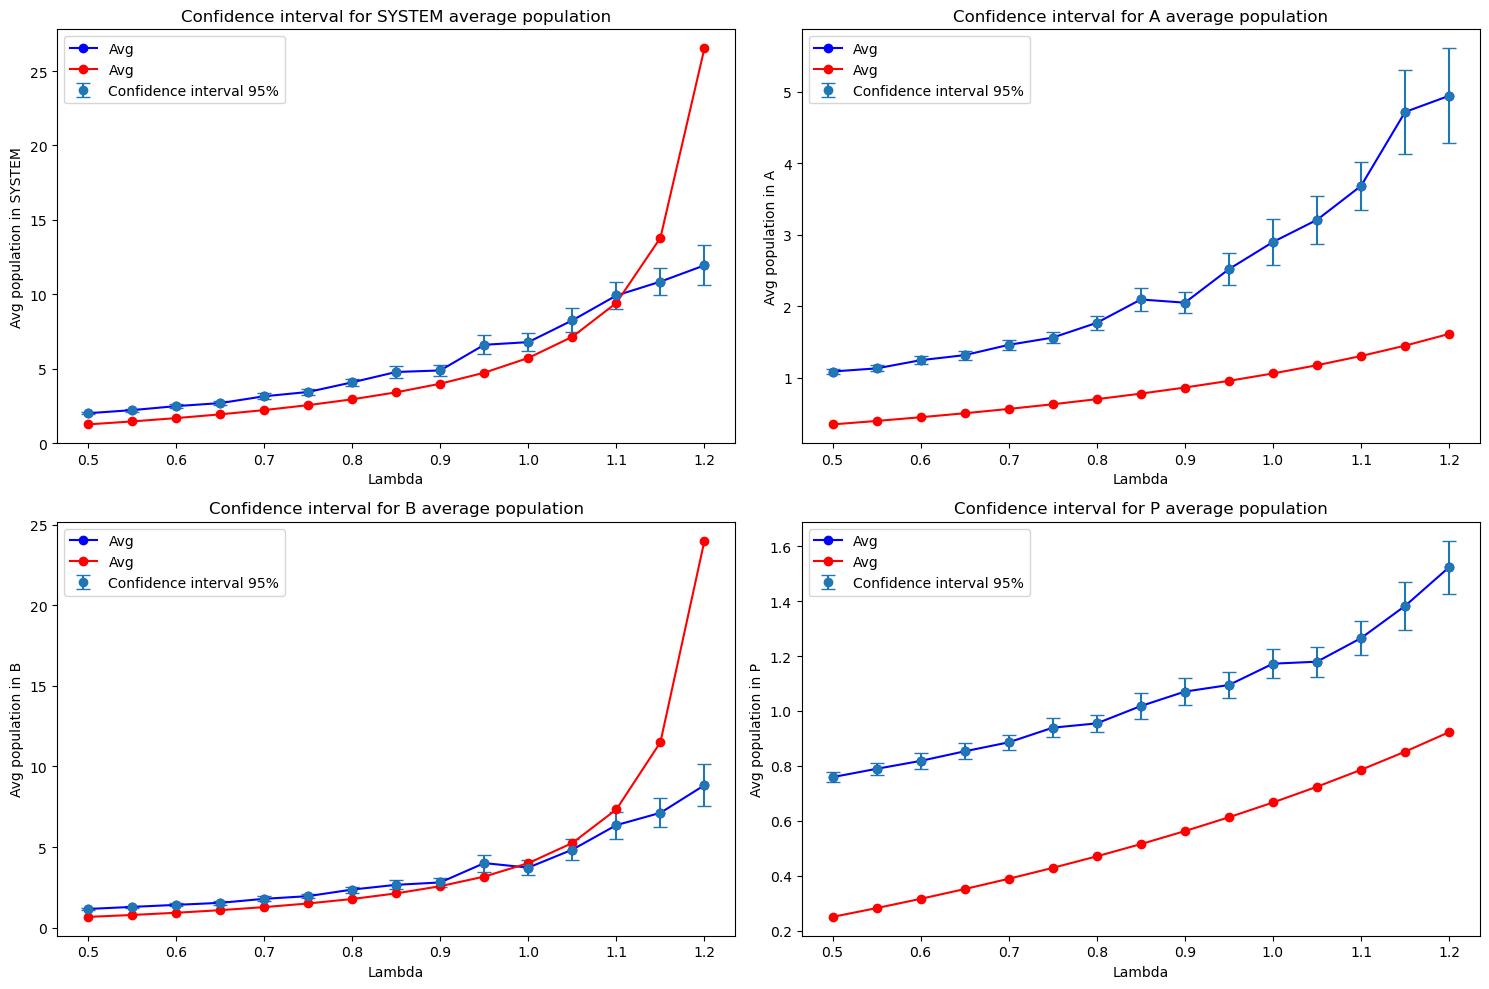

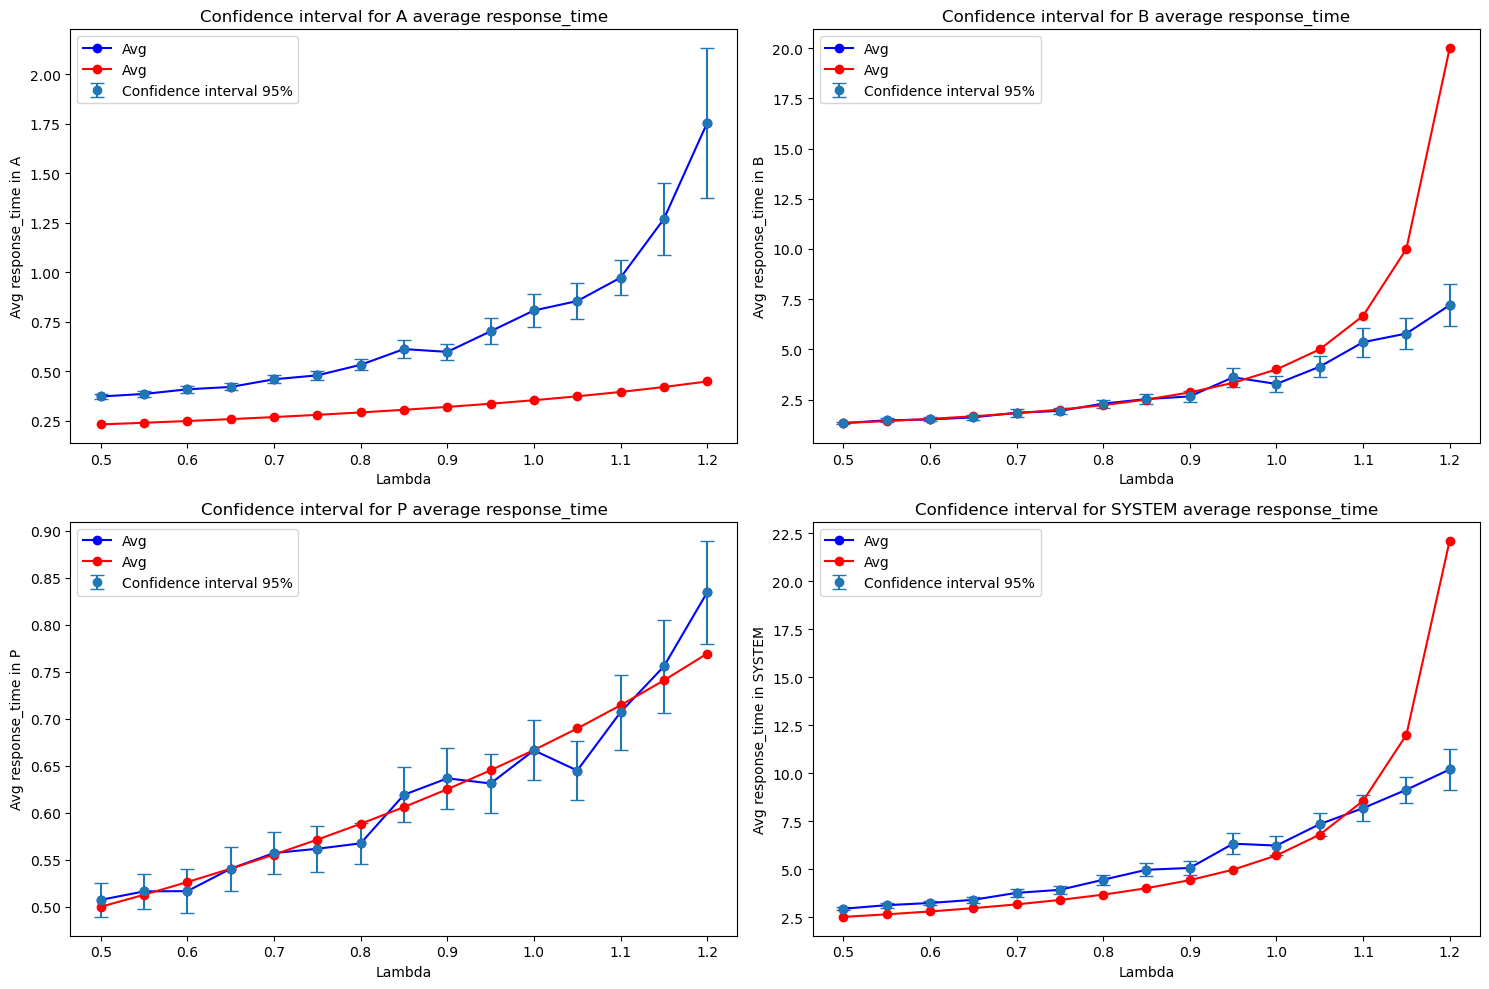

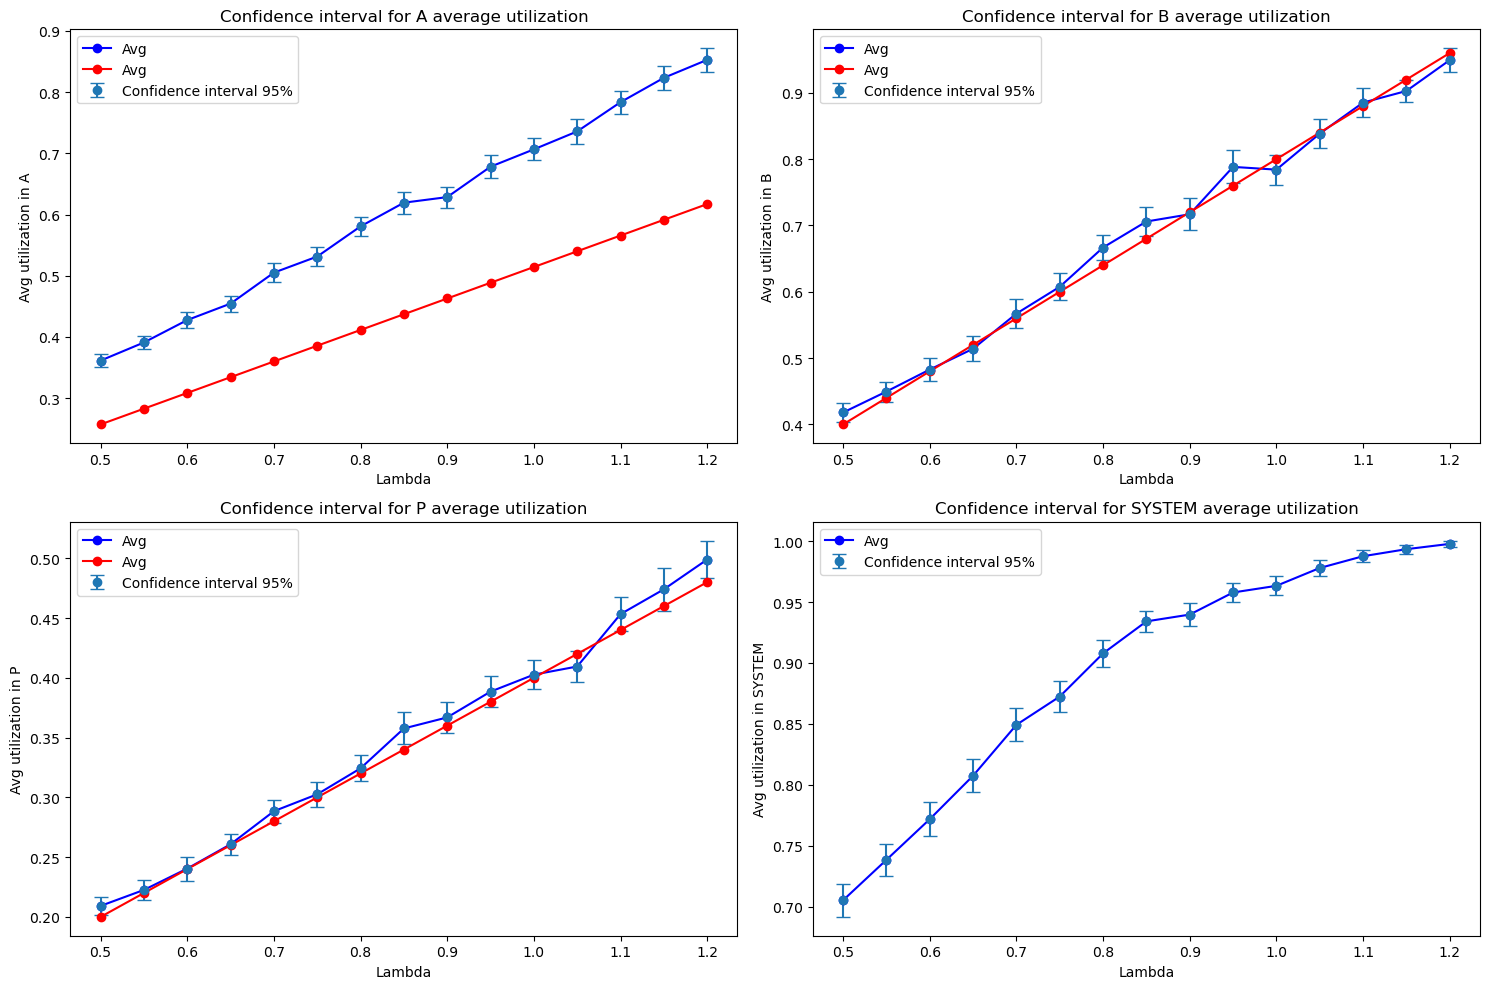

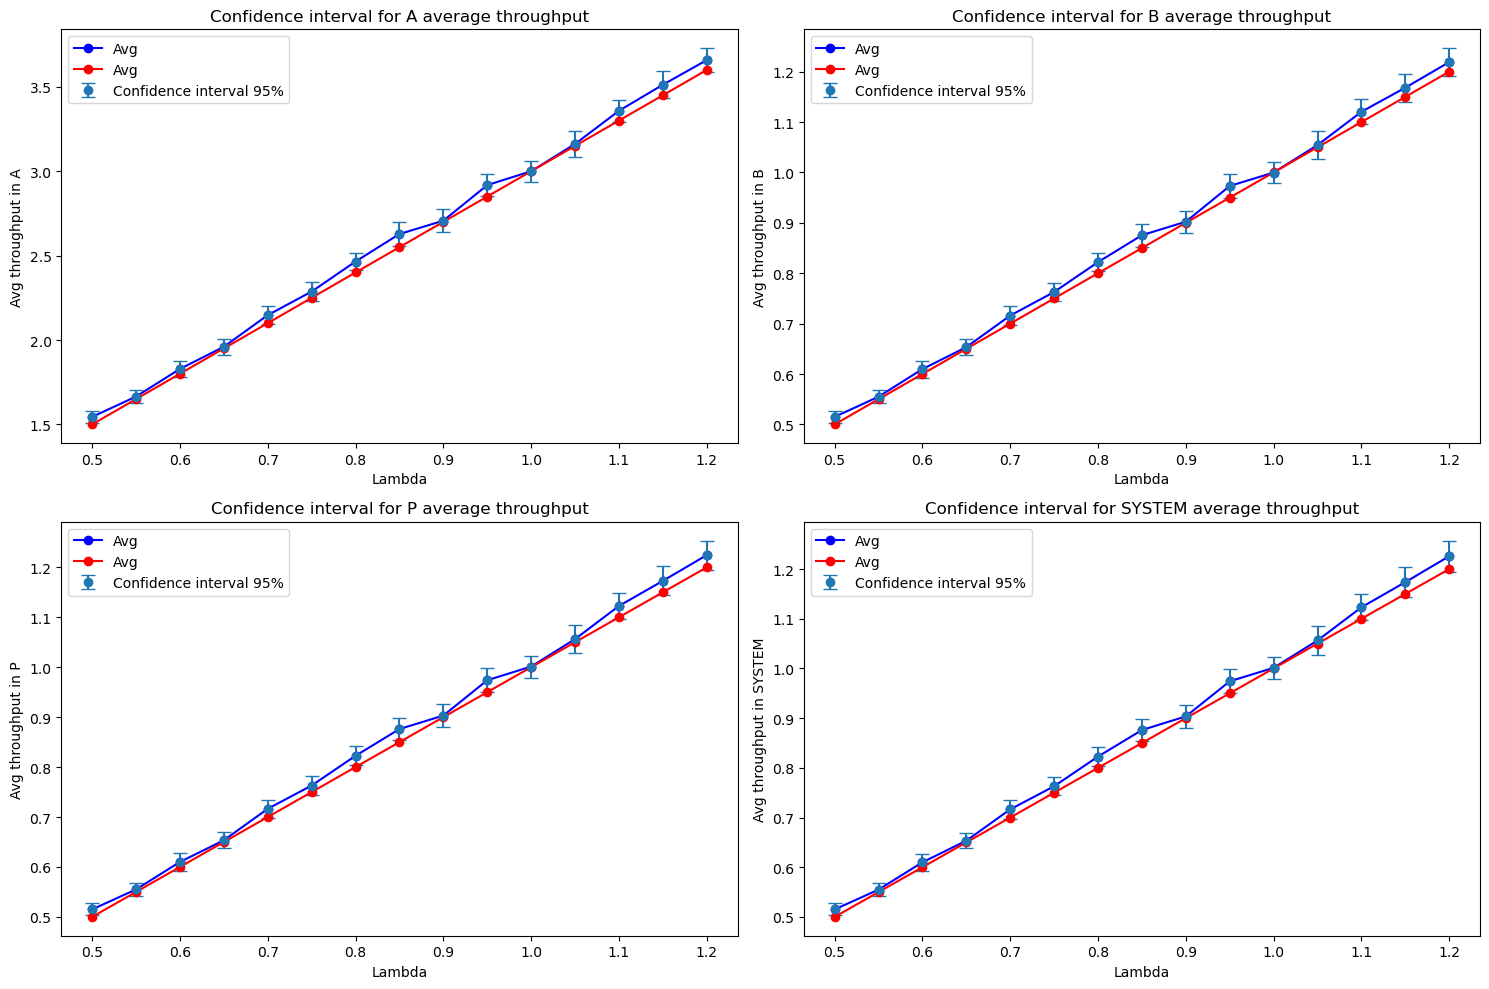

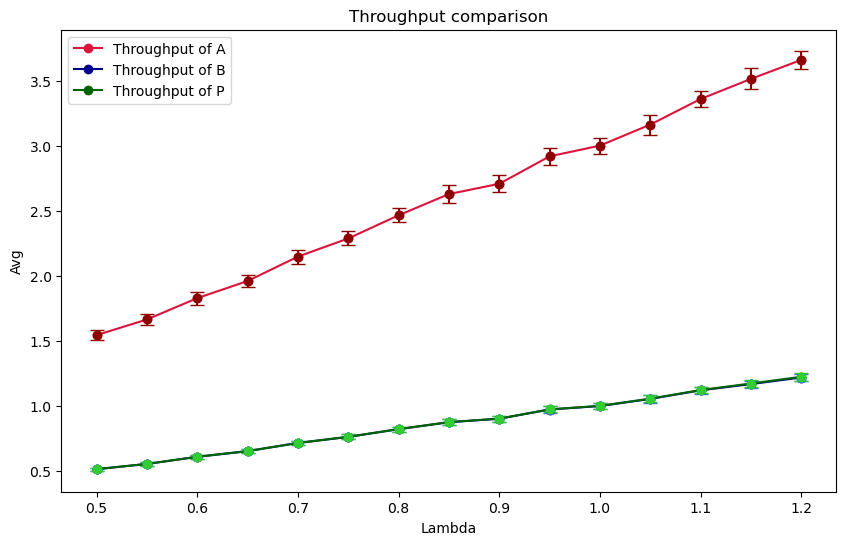

lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,SYSTEM,2.0137,1.26282,0.750875
0.55,population,SYSTEM,2.22038,1.46219,0.758193
0.6,population,SYSTEM,2.49056,1.68515,0.805416
0.65,population,SYSTEM,2.69254,1.93683,0.755711
0.7,population,SYSTEM,3.15061,2.22412,0.926493
0.75,population,SYSTEM,3.44145,2.55648,0.884974
0.8,population,SYSTEM,4.08742,2.9474,1.14003
0.85,population,SYSTEM,4.78367,3.4168,1.36687
0.9,population,SYSTEM,4.88707,3.99563,0.891442
0.95,population,SYSTEM,6.61115,4.73488,1.87628


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,A,1.08599,0.346154,0.739837
0.55,population,A,1.12957,0.394422,0.735143
0.6,population,A,1.244,0.446281,0.797722
0.65,population,A,1.31492,0.502146,0.812771
0.7,population,A,1.4585,0.5625,0.895999
0.75,population,A,1.56012,0.627907,0.932209
0.8,population,A,1.76677,0.699029,1.06774
0.85,population,A,2.09311,0.77665,1.31646
0.9,population,A,2.04853,0.861702,1.18682
0.95,population,A,2.51738,0.955307,1.56208


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,B,1.15858,0.666667,0.491911
0.55,population,B,1.2865,0.785714,0.500786
0.6,population,B,1.41289,0.923077,0.489814
0.65,population,B,1.53856,1.08333,0.455228
0.7,population,B,1.78709,1.27273,0.514365
0.75,population,B,1.9549,1.5,0.454903
0.8,population,B,2.36136,1.77778,0.583585
0.85,population,B,2.6569,2.125,0.531902
0.9,population,B,2.8034,2.57143,0.231976
0.95,population,B,4.00384,3.16667,0.837173


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,P,0.758962,0.25,0.508962
0.55,population,P,0.789266,0.282051,0.507214
0.6,population,P,0.818183,0.315789,0.502394
0.65,population,P,0.853055,0.351351,0.501704
0.7,population,P,0.885756,0.388889,0.496867
0.75,population,P,0.939114,0.428571,0.510542
0.8,population,P,0.954807,0.470588,0.484219
0.85,population,P,1.01795,0.515152,0.502798
0.9,population,P,1.07049,0.5625,0.507993
0.95,population,P,1.09453,0.612903,0.481631


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,A,0.371833,0.230769,0.141063
0.55,response_time,A,0.384672,0.239044,0.145628
0.6,response_time,A,0.408018,0.247934,0.160084
0.65,response_time,A,0.420098,0.257511,0.162587
0.7,response_time,A,0.458698,0.267857,0.19084
0.75,response_time,A,0.478535,0.27907,0.199465
0.8,response_time,A,0.531881,0.291262,0.240619
0.85,response_time,A,0.611246,0.304569,0.306678
0.9,response_time,A,0.597195,0.319149,0.278046
0.95,response_time,A,0.701222,0.335196,0.366026


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,B,1.32774,1.33333,0.00559564
0.55,response_time,B,1.46677,1.42857,0.0381961
0.6,response_time,B,1.51019,1.53846,0.0282735
0.65,response_time,B,1.61275,1.66667,0.0539159
0.7,response_time,B,1.84552,1.81818,0.0273381
0.75,response_time,B,1.93596,2,0.0640371
0.8,response_time,B,2.29901,2.22222,0.0767848
0.85,response_time,B,2.52487,2.5,0.0248709
0.9,response_time,B,2.65781,2.85714,0.199337
0.95,response_time,B,3.60769,3.33333,0.274357


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,P,0.50739,0.5,0.00739004
0.55,response_time,P,0.51639,0.512821,0.00356952
0.6,response_time,P,0.516684,0.526316,0.00963212
0.65,response_time,P,0.540507,0.540541,3.35734e-05
0.7,response_time,P,0.557197,0.555556,0.0016416
0.75,response_time,P,0.561719,0.571429,0.00970941
0.8,response_time,P,0.567469,0.588235,0.0207668
0.85,response_time,P,0.619114,0.606061,0.0130534
0.9,response_time,P,0.636573,0.625,0.0115734
0.95,response_time,P,0.631175,0.645161,0.0139859


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,SYSTEM,2.95018,2.52564,0.424534
0.55,response_time,SYSTEM,3.13651,2.65852,0.477986
0.6,response_time,SYSTEM,3.24939,2.80858,0.440815
0.65,response_time,SYSTEM,3.41501,2.97974,0.435267
0.7,response_time,SYSTEM,3.77743,3.17731,0.600125
0.75,response_time,SYSTEM,3.93499,3.40864,0.526353
0.8,response_time,SYSTEM,4.45982,3.68424,0.775578
0.85,response_time,SYSTEM,4.9786,4.01977,0.958829
0.9,response_time,SYSTEM,5.07527,4.43959,0.635677
0.95,response_time,SYSTEM,6.33671,4.98408,1.35262


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,A,0.361412,0.257143,0.104269
0.55,utilization,A,0.391026,0.282857,0.108169
0.6,utilization,A,0.42764,0.308571,0.119069
0.65,utilization,A,0.454549,0.334286,0.120263
0.7,utilization,A,0.505105,0.36,0.145105
0.75,utilization,A,0.531427,0.385714,0.145713
0.8,utilization,A,0.580721,0.411429,0.169292
0.85,utilization,A,0.619396,0.437143,0.182253
0.9,utilization,A,0.628525,0.462857,0.165668
0.95,utilization,A,0.678217,0.488571,0.189645


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,B,0.417963,0.4,0.0179633
0.55,utilization,B,0.449543,0.44,0.00954263
0.6,utilization,B,0.482736,0.48,0.00273569
0.65,utilization,B,0.514069,0.52,0.00593066
0.7,utilization,B,0.56708,0.56,0.00708025
0.75,utilization,B,0.607507,0.6,0.00750709
0.8,utilization,B,0.666769,0.64,0.0267691
0.85,utilization,B,0.705976,0.68,0.025976
0.9,utilization,B,0.716911,0.72,0.0030892
0.95,utilization,B,0.788348,0.76,0.0283484


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,P,0.209211,0.2,0.00921146
0.55,utilization,P,0.222568,0.22,0.00256823
0.6,utilization,P,0.240422,0.24,0.000421547
0.65,utilization,P,0.260786,0.26,0.000786077
0.7,utilization,P,0.288431,0.28,0.00843144
0.75,utilization,P,0.302579,0.3,0.00257898
0.8,utilization,P,0.324303,0.32,0.0043029
0.85,utilization,P,0.357637,0.34,0.0176367
0.9,utilization,P,0.366885,0.36,0.00688529
0.95,utilization,P,0.388454,0.38,0.00845354


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,A,1.54457,1.5,0.0445688
0.55,throughput,A,1.66476,1.65,0.0147595
0.6,throughput,A,1.82865,1.8,0.02865
0.65,throughput,A,1.95999,1.95,0.00998787
0.7,throughput,A,2.14745,2.1,0.0474525
0.75,throughput,A,2.28705,2.25,0.0370524
0.8,throughput,A,2.46494,2.4,0.0649412
0.85,throughput,A,2.62794,2.55,0.0779396
0.9,throughput,A,2.70699,2.7,0.00699252
0.95,throughput,A,2.91771,2.85,0.0677111


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,B,0.514923,0.5,0.0149226
0.55,throughput,B,0.554917,0.55,0.00491744
0.6,throughput,B,0.609776,0.6,0.00977634
0.65,throughput,B,0.653315,0.65,0.00331519
0.7,throughput,B,0.716028,0.7,0.0160284
0.75,throughput,B,0.762753,0.75,0.0127529
0.8,throughput,B,0.822069,0.8,0.0220694
0.85,throughput,B,0.875441,0.85,0.0254407
0.9,throughput,B,0.902198,0.9,0.00219765
0.95,throughput,B,0.973134,0.95,0.0231335


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,P,0.515028,0.5,0.0150276
0.55,throughput,P,0.55502,0.55,0.00501969
0.6,throughput,P,0.610018,0.6,0.0100184
0.65,throughput,P,0.653442,0.65,0.00344162
0.7,throughput,P,0.716483,0.7,0.0164833
0.75,throughput,P,0.763051,0.75,0.0130508
0.8,throughput,P,0.822593,0.8,0.0225927
0.85,throughput,P,0.876135,0.85,0.0261347
0.9,throughput,P,0.903149,0.9,0.00314891
0.95,throughput,P,0.973901,0.95,0.0239012


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,SYSTEM,0.515024,0.5,0.0150237
0.55,throughput,SYSTEM,0.554928,0.55,0.00492809
0.6,throughput,SYSTEM,0.609891,0.6,0.00989098
0.65,throughput,SYSTEM,0.653364,0.65,0.00336424
0.7,throughput,SYSTEM,0.716415,0.7,0.0164153
0.75,throughput,SYSTEM,0.762933,0.75,0.0129333
0.8,throughput,SYSTEM,0.822677,0.8,0.0226771
0.85,throughput,SYSTEM,0.876048,0.85,0.0260485
0.9,throughput,SYSTEM,0.903489,0.9,0.00348916
0.95,throughput,SYSTEM,0.974094,0.95,0.0240937


In [29]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1")
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj1'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analytical_perf = analitycal_preprocessing(obj)

#boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analytical_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analytical_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 2

The model adds the functionality of two-factor authentication, observe the three metrics variation.

(6000, 4) Index(['iteration', 'busytime', 'lambda', 'node'], dtype='object')
(1500, 4) Index(['iteration', 'observation_time', 'lambda', 'node'], dtype='object')
(6000, 4) Index(['iteration', 'completions', 'lambda', 'node'], dtype='object')
(1500, 4) Index(['iteration', 'observation_time', 'lambda', 'node'], dtype='object')


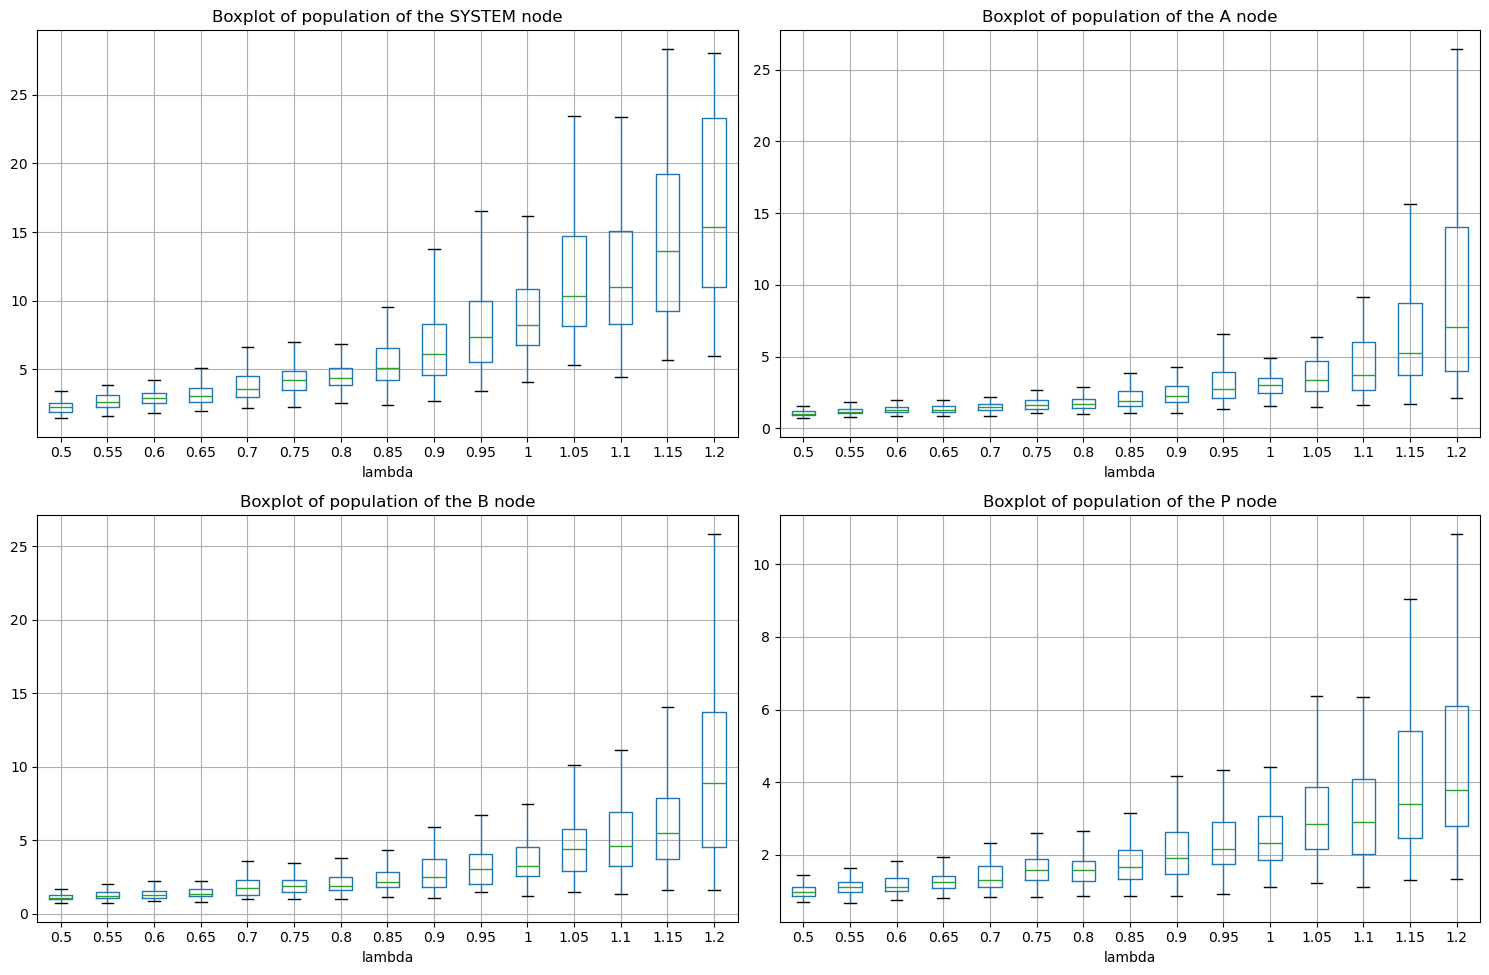

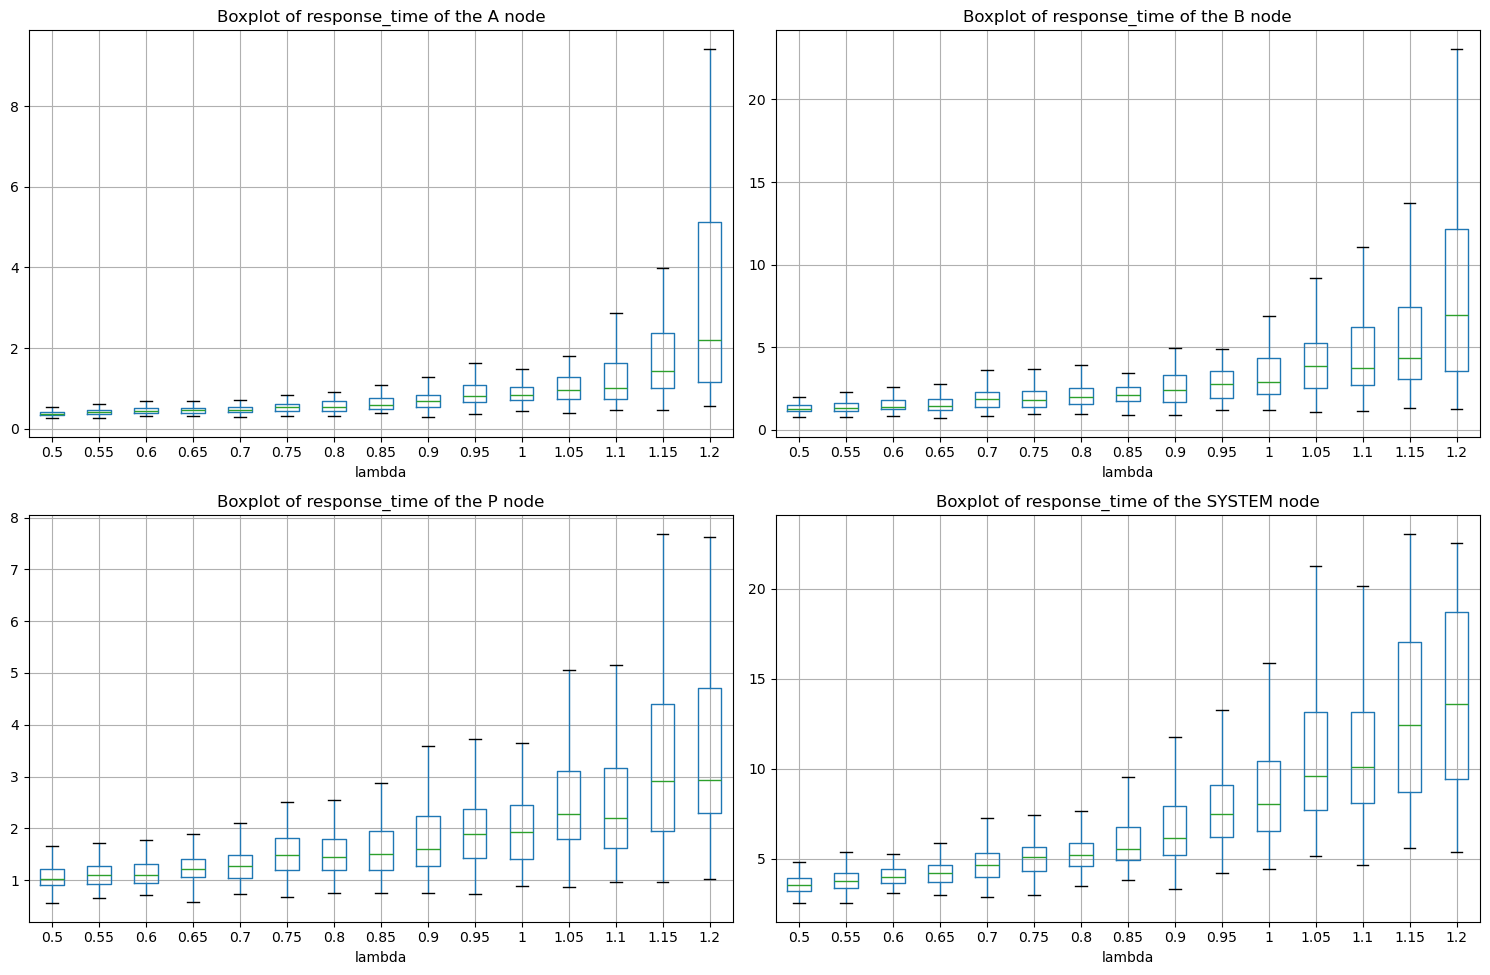

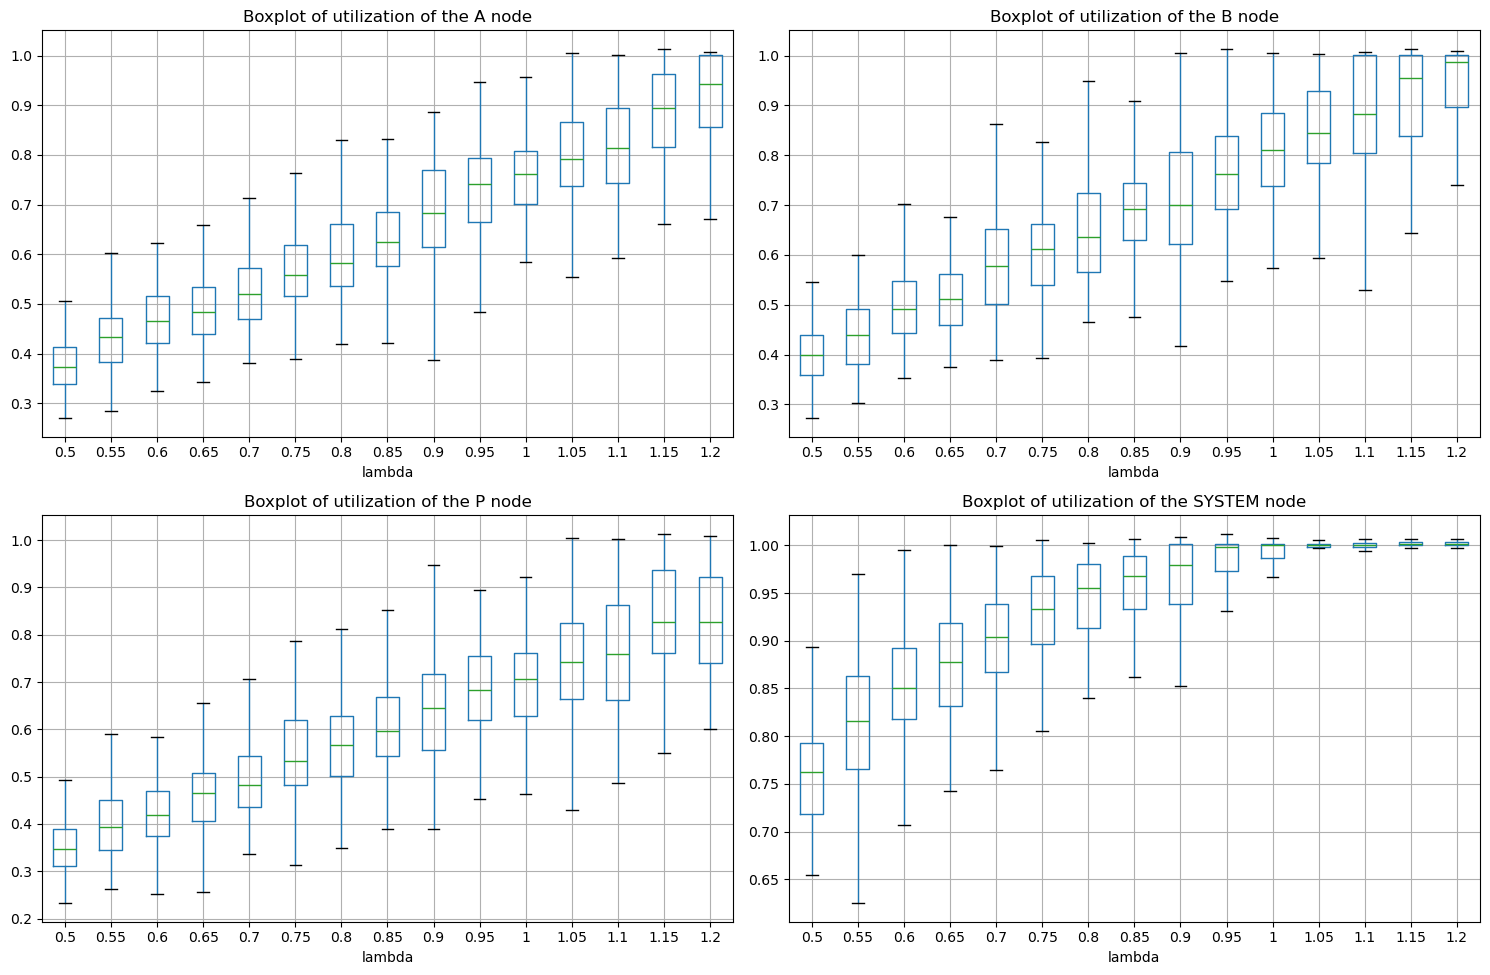

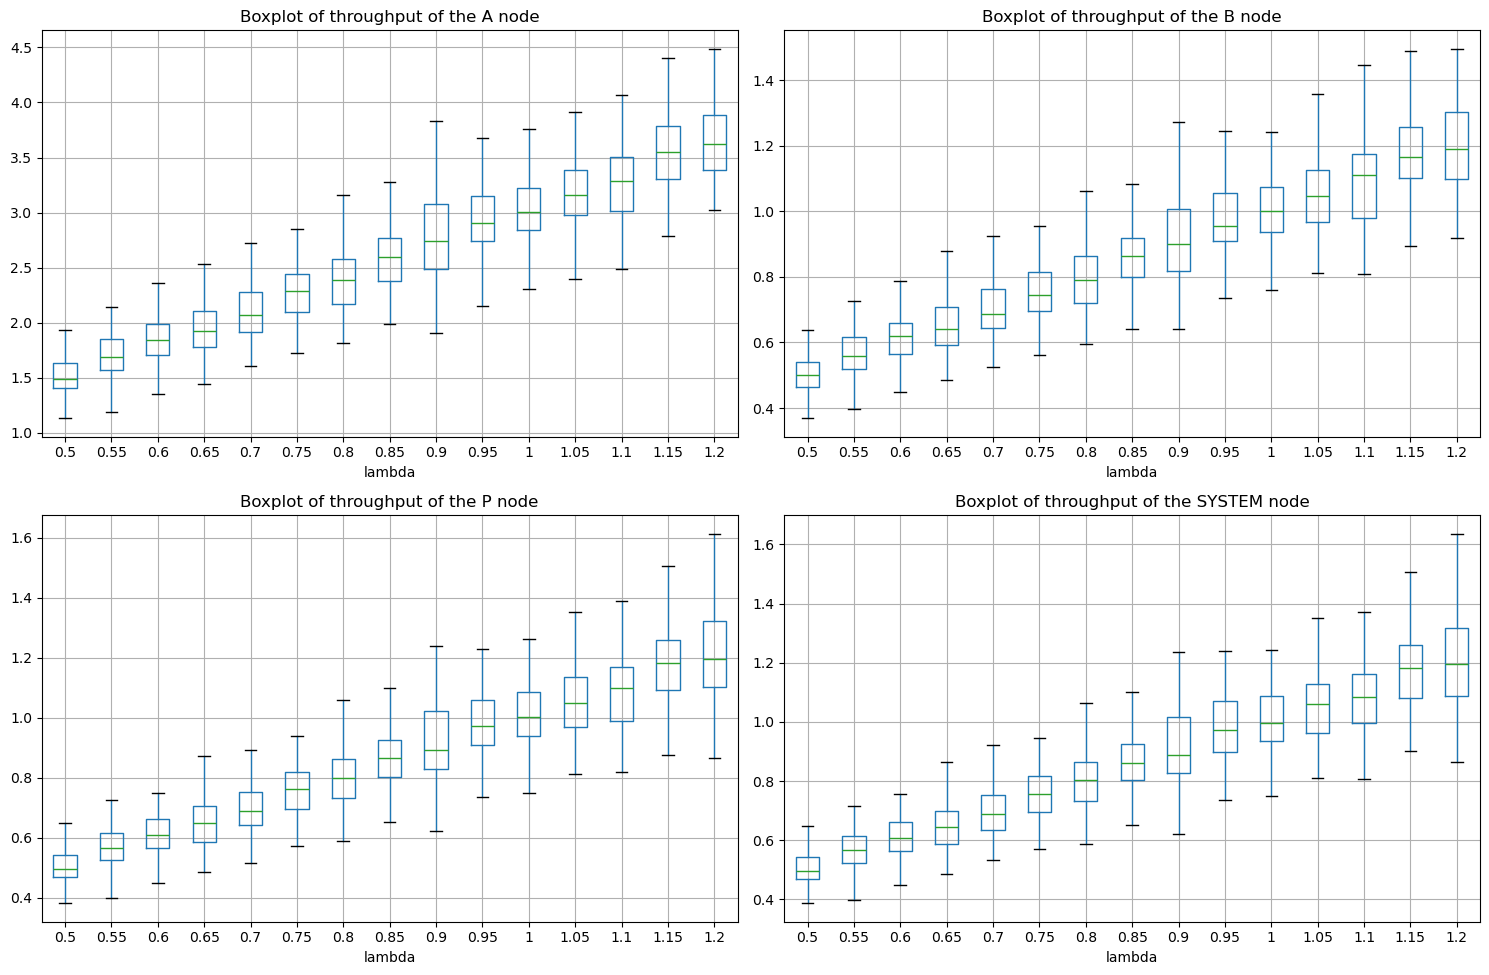

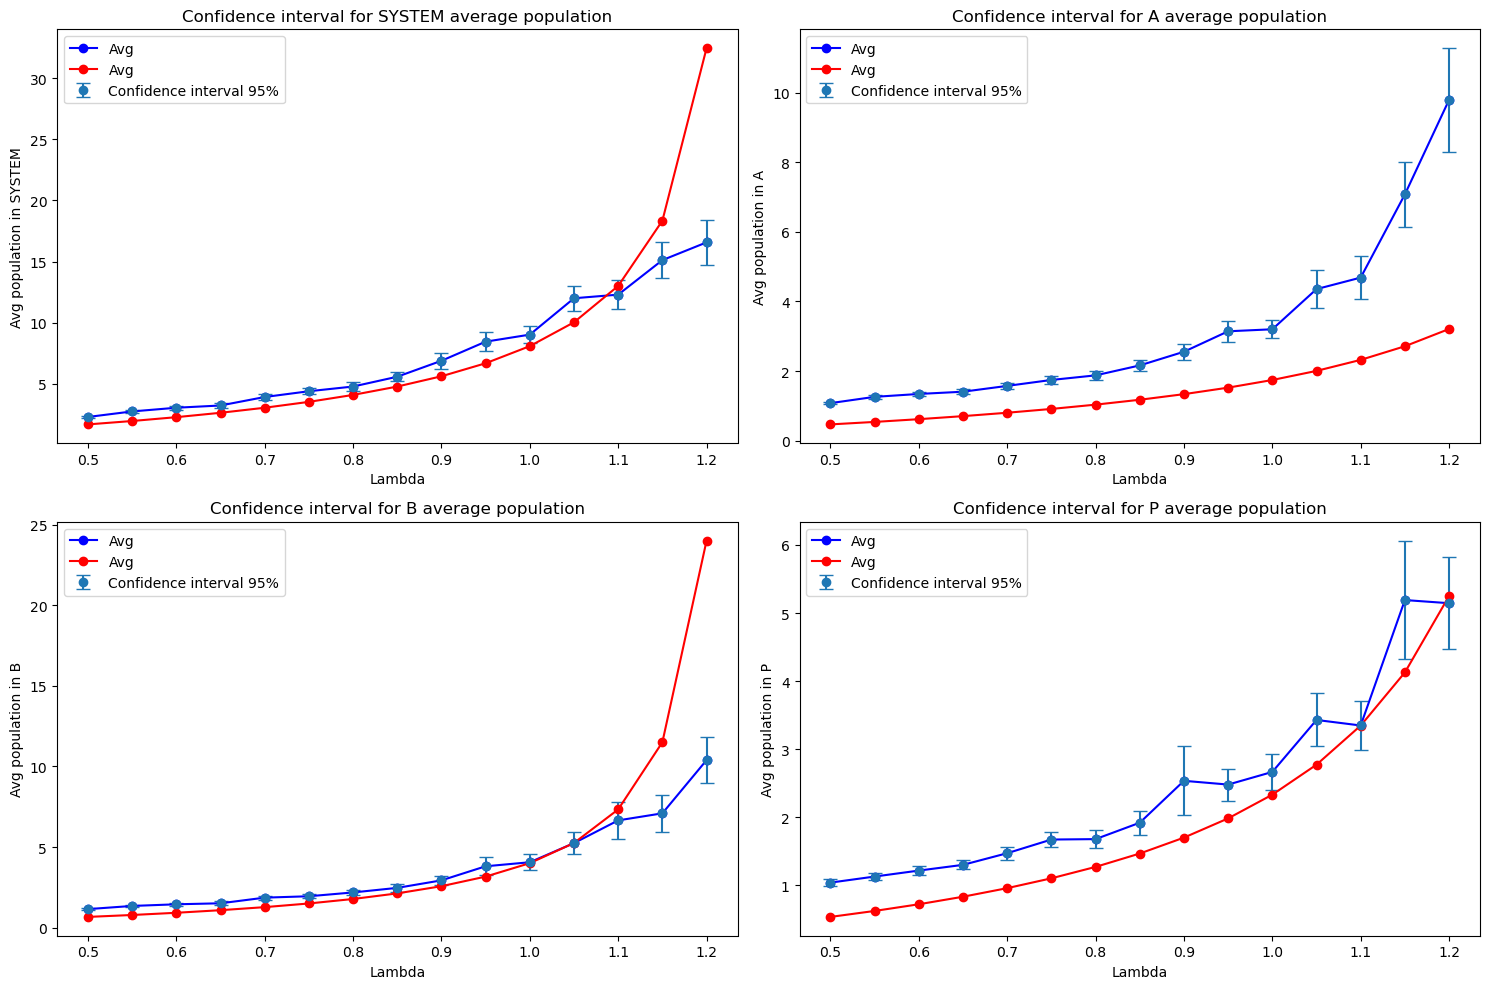

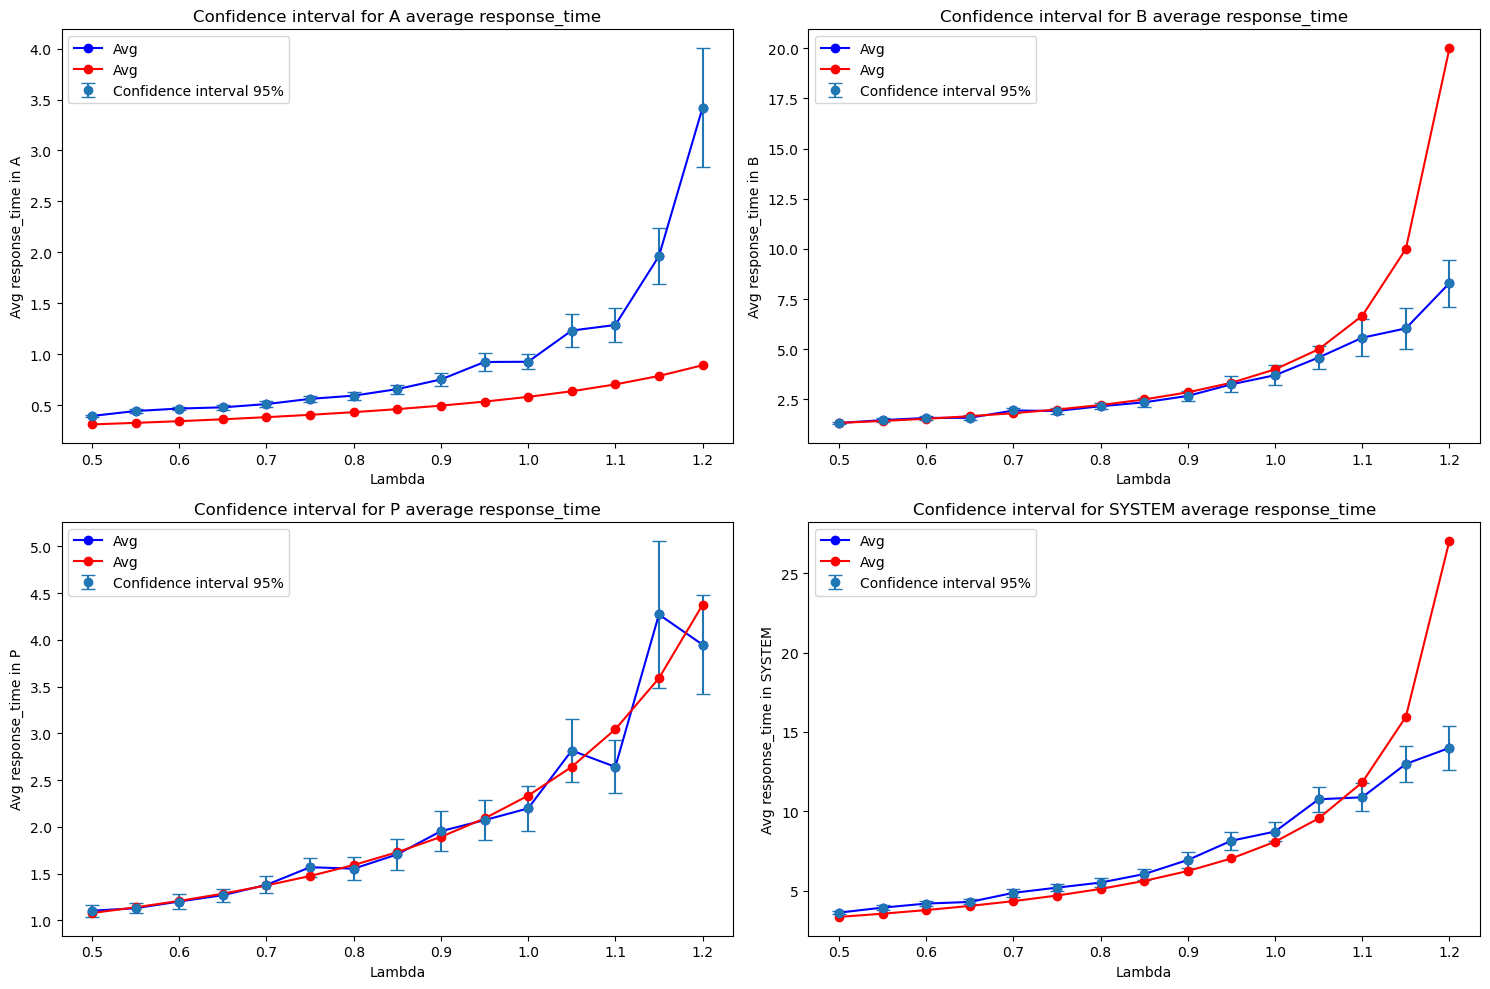

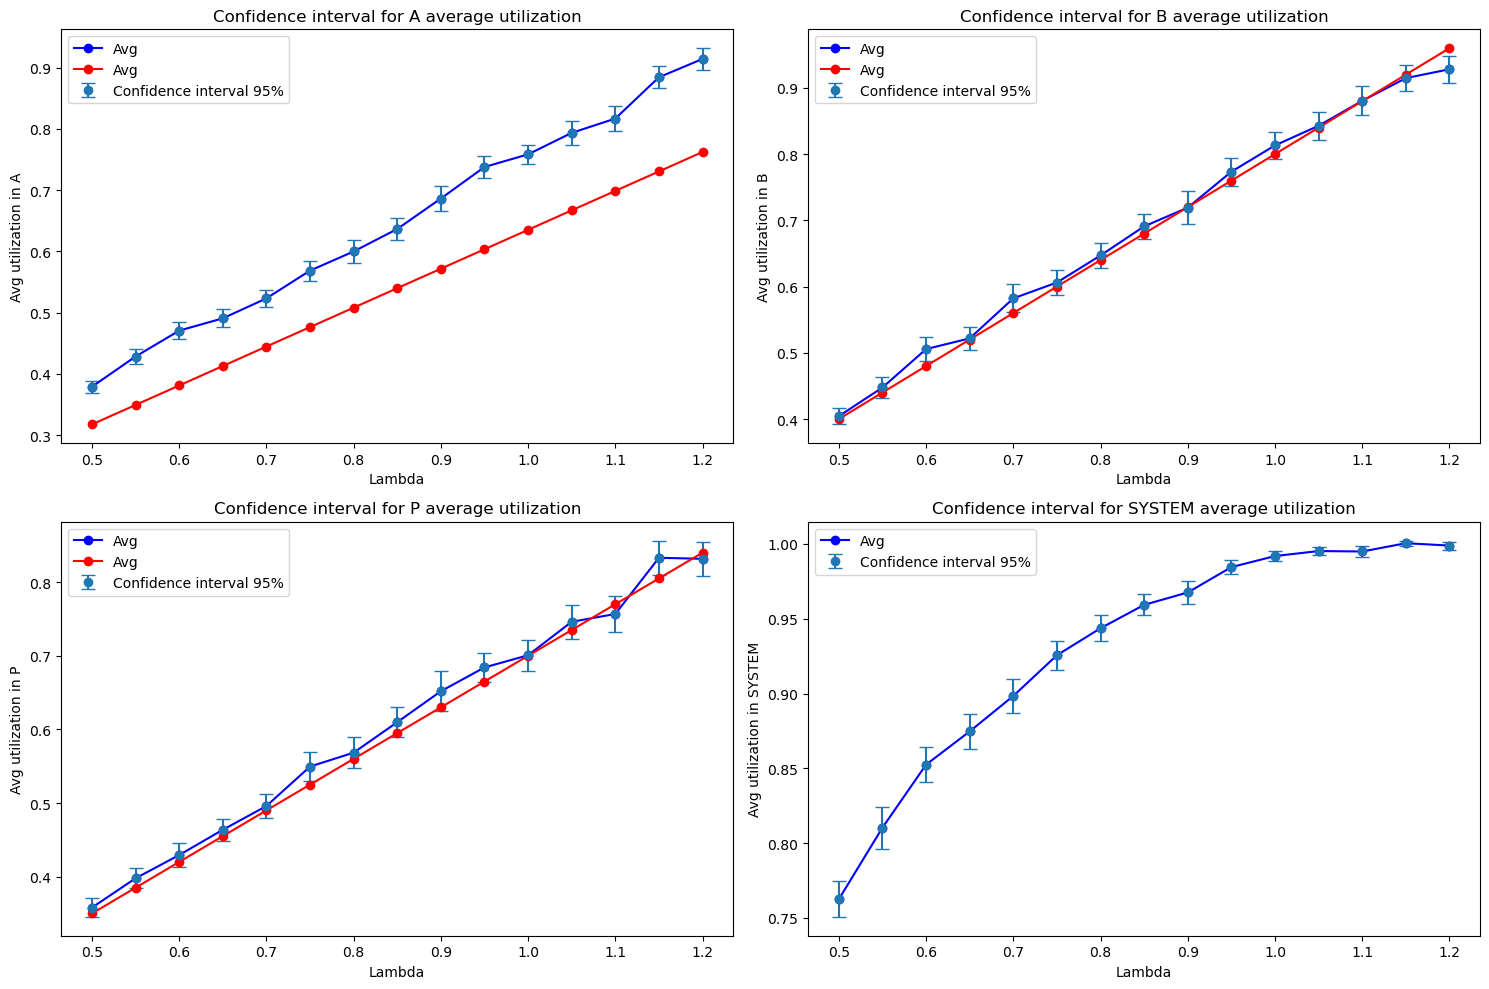

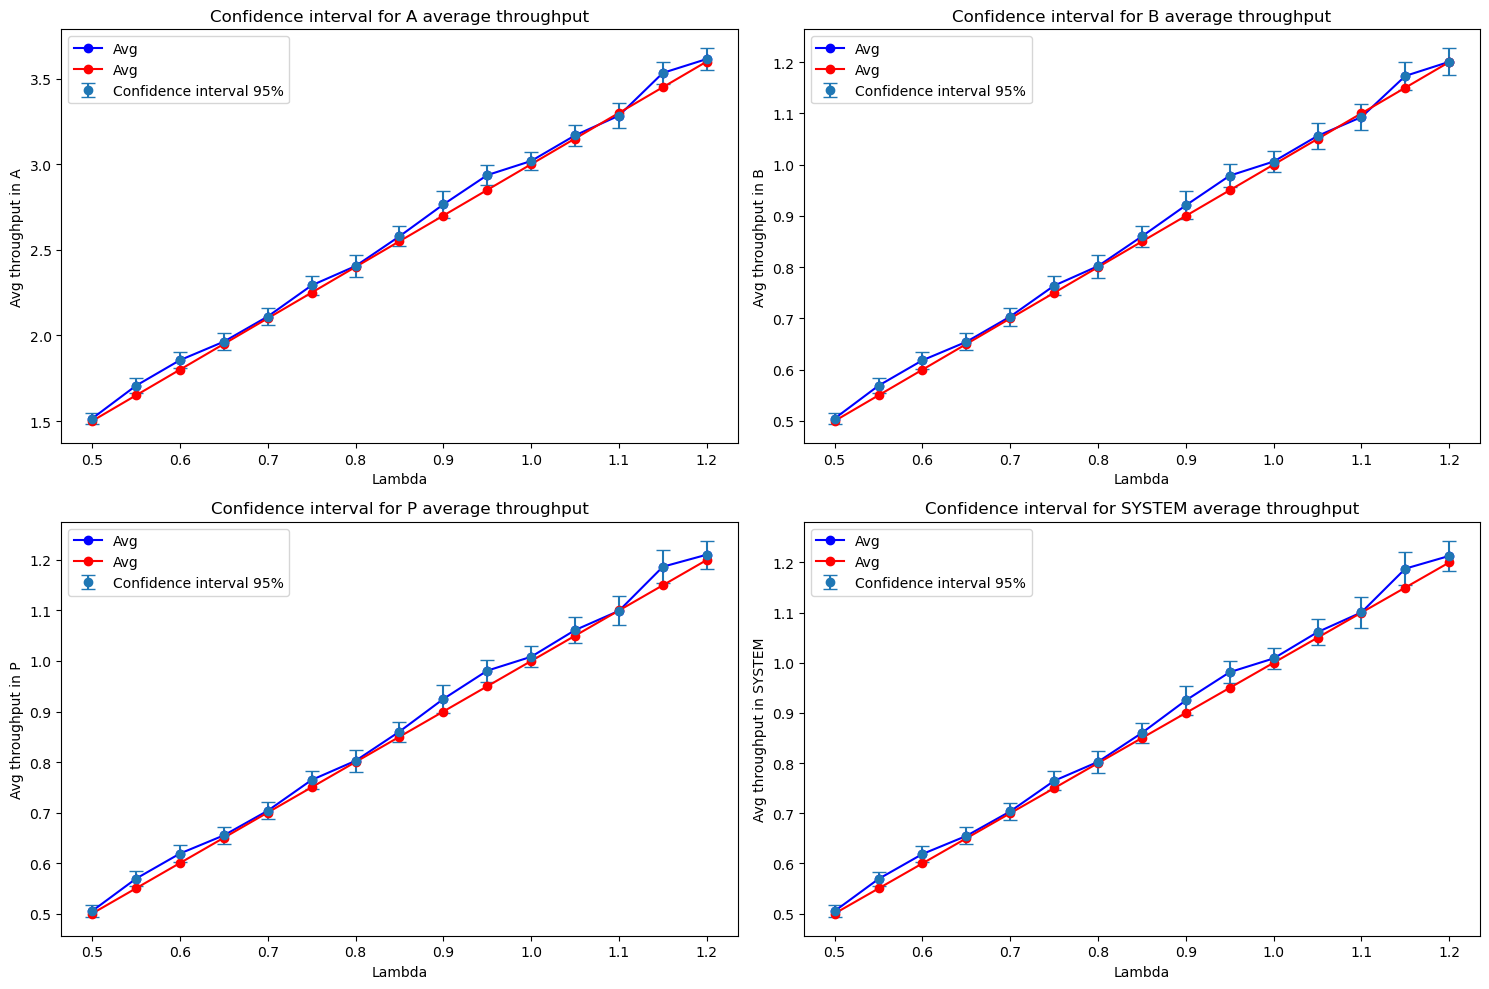

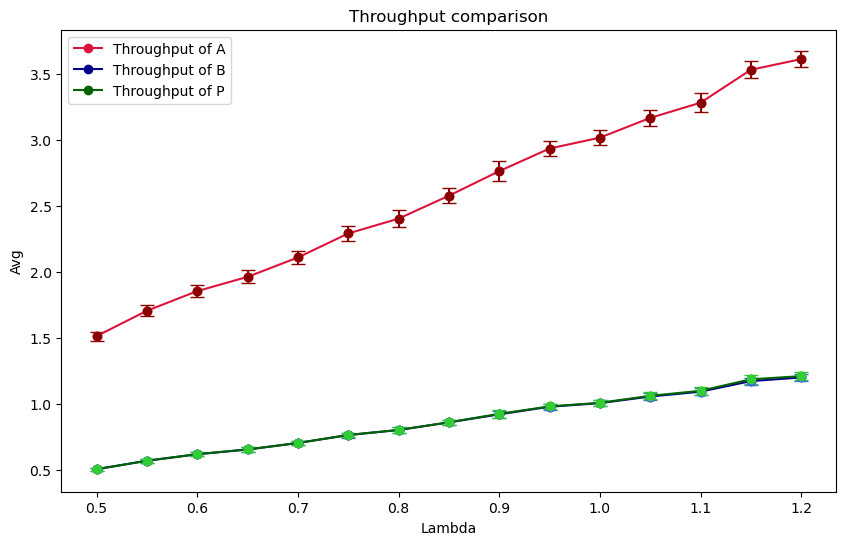

lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,SYSTEM,2.27905,1.67065,0.608405
0.55,population,SYSTEM,2.73199,1.9488,0.783184
0.6,population,SYSTEM,3.03478,2.26318,0.7716
0.65,population,SYSTEM,3.21868,2.6216,0.597077
0.7,population,SYSTEM,3.91247,3.03436,0.878106
0.75,population,SYSTEM,4.38465,3.51538,0.869276
0.8,population,SYSTEM,4.76953,4.084,0.685533
0.85,population,SYSTEM,5.57235,4.76805,0.804302
0.9,population,SYSTEM,6.87758,5.6093,1.26828
0.95,population,SYSTEM,8.44116,6.674,1.76716


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,A,1.07693,0.465517,0.611412
0.55,population,A,1.25759,0.537071,0.720521
0.6,population,A,1.34079,0.61597,0.724819
0.65,population,A,1.40525,0.703407,0.701839
0.7,population,A,1.57257,0.800847,0.771718
0.75,population,A,1.74303,0.910112,0.83292
0.8,population,A,1.87493,1.03349,0.841434
0.85,population,A,2.16103,1.17391,0.987117
0.9,population,A,2.55392,1.33516,1.21876
0.95,population,A,3.14214,1.52226,1.61989


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,B,1.15047,0.666667,0.483807
0.55,population,B,1.3465,0.785714,0.560785
0.6,population,B,1.44898,0.923077,0.525901
0.65,population,B,1.51119,1.08333,0.427858
0.7,population,B,1.86117,1.27273,0.588444
0.75,population,B,1.94782,1.5,0.447824
0.8,population,B,2.18354,1.77778,0.405762
0.85,population,B,2.46742,2.125,0.342421
0.9,population,B,2.93314,2.57143,0.361716
0.95,population,B,3.80672,3.16667,0.640051


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,P,1.042,0.538462,0.503539
0.55,population,P,1.13109,0.626016,0.505072
0.6,population,P,1.2188,0.724138,0.494657
0.65,population,P,1.30283,0.834862,0.46797
0.7,population,P,1.47394,0.960784,0.513152
0.75,population,P,1.67448,1.10526,0.569213
0.8,population,P,1.68071,1.27273,0.40798
0.85,population,P,1.92137,1.46914,0.452238
0.9,population,P,2.53695,1.7027,0.834246
0.95,population,P,2.48164,1.98507,0.496561


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,A,0.393381,0.310345,0.0830363
0.55,response_time,A,0.441879,0.325497,0.116382
0.6,response_time,A,0.466081,0.342205,0.123875
0.65,response_time,A,0.478044,0.360721,0.117323
0.7,response_time,A,0.509991,0.381356,0.128635
0.75,response_time,A,0.561163,0.404494,0.156669
0.8,response_time,A,0.592693,0.430622,0.162071
0.85,response_time,A,0.656828,0.460358,0.19647
0.9,response_time,A,0.751727,0.494505,0.257221
0.95,response_time,A,0.923287,0.534125,0.389162


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,B,1.3282,1.33333,0.00513488
0.55,response_time,B,1.47196,1.42857,0.0433887
0.6,response_time,B,1.58103,1.53846,0.0425639
0.65,response_time,B,1.58643,1.66667,0.0802377
0.7,response_time,B,1.95114,1.81818,0.132955
0.75,response_time,B,1.92742,2,0.0725813
0.8,response_time,B,2.16298,2.22222,0.0592397
0.85,response_time,B,2.35726,2.5,0.142738
0.9,response_time,B,2.67736,2.85714,0.179783
0.95,response_time,B,3.25462,3.33333,0.0787114


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,P,1.10172,1.07692,0.0248004
0.55,response_time,P,1.12881,1.13821,0.00940542
0.6,response_time,P,1.20047,1.2069,0.0064283
0.65,response_time,P,1.2682,1.2844,0.0162024
0.7,response_time,P,1.37876,1.37255,0.00620759
0.75,response_time,P,1.56768,1.47368,0.0939933
0.8,response_time,P,1.55169,1.59091,0.0392172
0.85,response_time,P,1.70484,1.7284,0.023556
0.9,response_time,P,1.9533,1.89189,0.0614087
0.95,response_time,P,2.07126,2.08955,0.0182929


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,SYSTEM,3.61129,3.34129,0.269999
0.55,response_time,SYSTEM,3.92601,3.54327,0.382739
0.6,response_time,SYSTEM,4.1813,3.77197,0.409325
0.65,response_time,SYSTEM,4.28434,4.03323,0.251108
0.7,response_time,SYSTEM,4.85754,4.3348,0.522745
0.75,response_time,SYSTEM,5.18534,4.68717,0.498171
0.8,response_time,SYSTEM,5.50437,5.105,0.399376
0.85,response_time,SYSTEM,6.04056,5.60947,0.431093
0.9,response_time,SYSTEM,6.92802,6.23255,0.695469
0.95,response_time,SYSTEM,8.14275,7.02526,1.11749


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,A,0.379118,0.317647,0.0614705
0.55,utilization,A,0.42842,0.349412,0.0790086
0.6,utilization,A,0.470717,0.381176,0.0895402
0.65,utilization,A,0.490765,0.412941,0.077824
0.7,utilization,A,0.523369,0.444706,0.0786631
0.75,utilization,A,0.56866,0.476471,0.0921897
0.8,utilization,A,0.599949,0.508235,0.0917132
0.85,utilization,A,0.636612,0.54,0.0966117
0.9,utilization,A,0.686341,0.571765,0.114576
0.95,utilization,A,0.737805,0.603529,0.134275


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,B,0.404312,0.4,0.00431216
0.55,utilization,B,0.447586,0.44,0.00758637
0.6,utilization,B,0.505595,0.48,0.0255946
0.65,utilization,B,0.521777,0.52,0.00177685
0.7,utilization,B,0.582198,0.56,0.0221983
0.75,utilization,B,0.606126,0.6,0.00612639
0.8,utilization,B,0.647039,0.64,0.00703915
0.85,utilization,B,0.690893,0.68,0.0108934
0.9,utilization,B,0.719233,0.72,0.00076722
0.95,utilization,B,0.773441,0.76,0.0134406


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,P,0.357995,0.35,0.00799496
0.55,utilization,P,0.397779,0.385,0.0127791
0.6,utilization,P,0.429365,0.42,0.00936525
0.65,utilization,P,0.463657,0.455,0.00865749
0.7,utilization,P,0.495934,0.49,0.00593413
0.75,utilization,P,0.549531,0.525,0.0245315
0.8,utilization,P,0.568397,0.56,0.00839728
0.85,utilization,P,0.609796,0.595,0.0147959
0.9,utilization,P,0.651822,0.63,0.0218221
0.95,utilization,P,0.684159,0.665,0.0191585


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,A,1.51446,1.5,0.0144617
0.55,throughput,A,1.70652,1.65,0.0565181
0.6,throughput,A,1.85545,1.8,0.0554509
0.65,throughput,A,1.9635,1.95,0.0135012
0.7,throughput,A,2.11048,2.1,0.0104843
0.75,throughput,A,2.29243,2.25,0.0424288
0.8,throughput,A,2.40501,2.4,0.00500731
0.85,throughput,A,2.57877,2.55,0.0287718
0.9,throughput,A,2.76505,2.7,0.0650468
0.95,throughput,A,2.93648,2.85,0.0864754


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,B,0.504805,0.5,0.00480476
0.55,throughput,B,0.568845,0.55,0.0188445
0.6,throughput,B,0.618315,0.6,0.0183151
0.65,throughput,B,0.654281,0.65,0.00428121
0.7,throughput,B,0.703592,0.7,0.00359216
0.75,throughput,B,0.763876,0.75,0.0138756
0.8,throughput,B,0.802008,0.8,0.00200785
0.85,throughput,B,0.86006,0.85,0.0100599
0.9,throughput,B,0.920517,0.9,0.0205166
0.95,throughput,B,0.978449,0.95,0.0284487


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,P,0.505001,0.5,0.00500135
0.55,throughput,P,0.569139,0.55,0.0191393
0.6,throughput,P,0.61879,0.6,0.01879
0.65,throughput,P,0.654809,0.65,0.00480903
0.7,throughput,P,0.703571,0.7,0.00357059
0.75,throughput,P,0.764489,0.75,0.0144893
0.8,throughput,P,0.802413,0.8,0.00241337
0.85,throughput,P,0.860226,0.85,0.0102263
0.9,throughput,P,0.92482,0.9,0.0248198
0.95,throughput,P,0.980866,0.95,0.0308656


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,SYSTEM,0.504896,0.5,0.00489566
0.55,throughput,SYSTEM,0.568993,0.55,0.0189927
0.6,throughput,SYSTEM,0.618687,0.6,0.0186873
0.65,throughput,SYSTEM,0.654742,0.65,0.00474186
0.7,throughput,SYSTEM,0.703699,0.7,0.00369908
0.75,throughput,SYSTEM,0.76465,0.75,0.0146497
0.8,throughput,SYSTEM,0.802471,0.8,0.00247092
0.85,throughput,SYSTEM,0.86021,0.85,0.0102096
0.9,throughput,SYSTEM,0.925088,0.9,0.0250881
0.95,throughput,SYSTEM,0.981255,0.95,0.0312546


In [30]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_2")
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj2'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analytical_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analytical_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analytical_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 3

Measure the metrics with an increased workload from 4200 req/h to 5000 req/h

(7600, 4) Index(['iteration', 'busytime', 'lambda', 'node'], dtype='object')
(1900, 4) Index(['iteration', 'observation_time', 'lambda', 'node'], dtype='object')
(7600, 4) Index(['iteration', 'completions', 'lambda', 'node'], dtype='object')
(1900, 4) Index(['iteration', 'observation_time', 'lambda', 'node'], dtype='object')


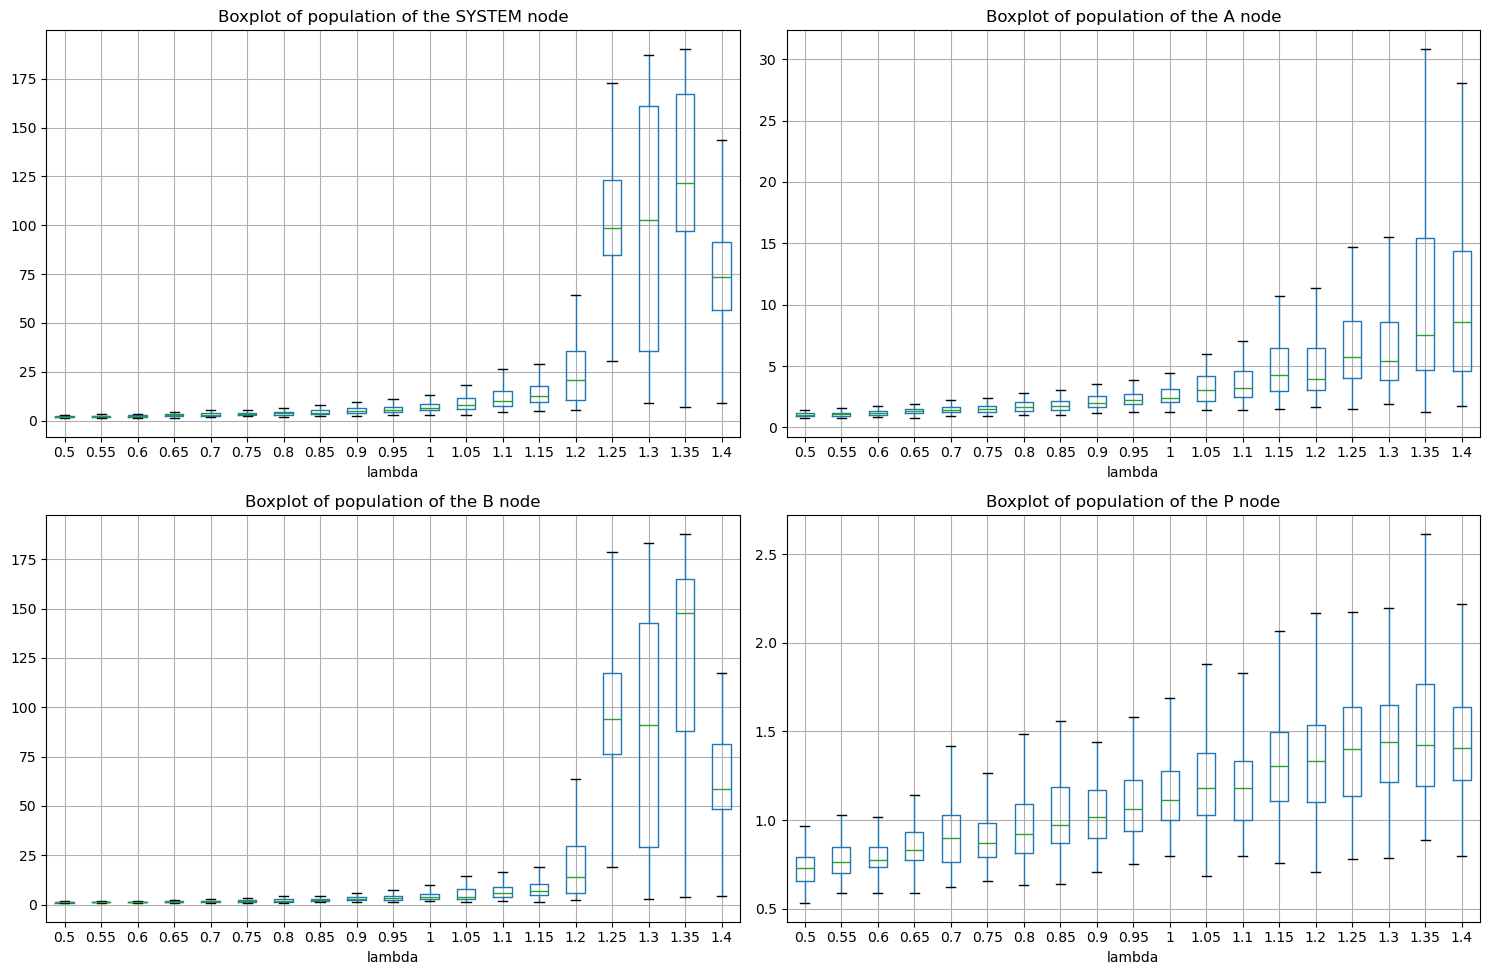

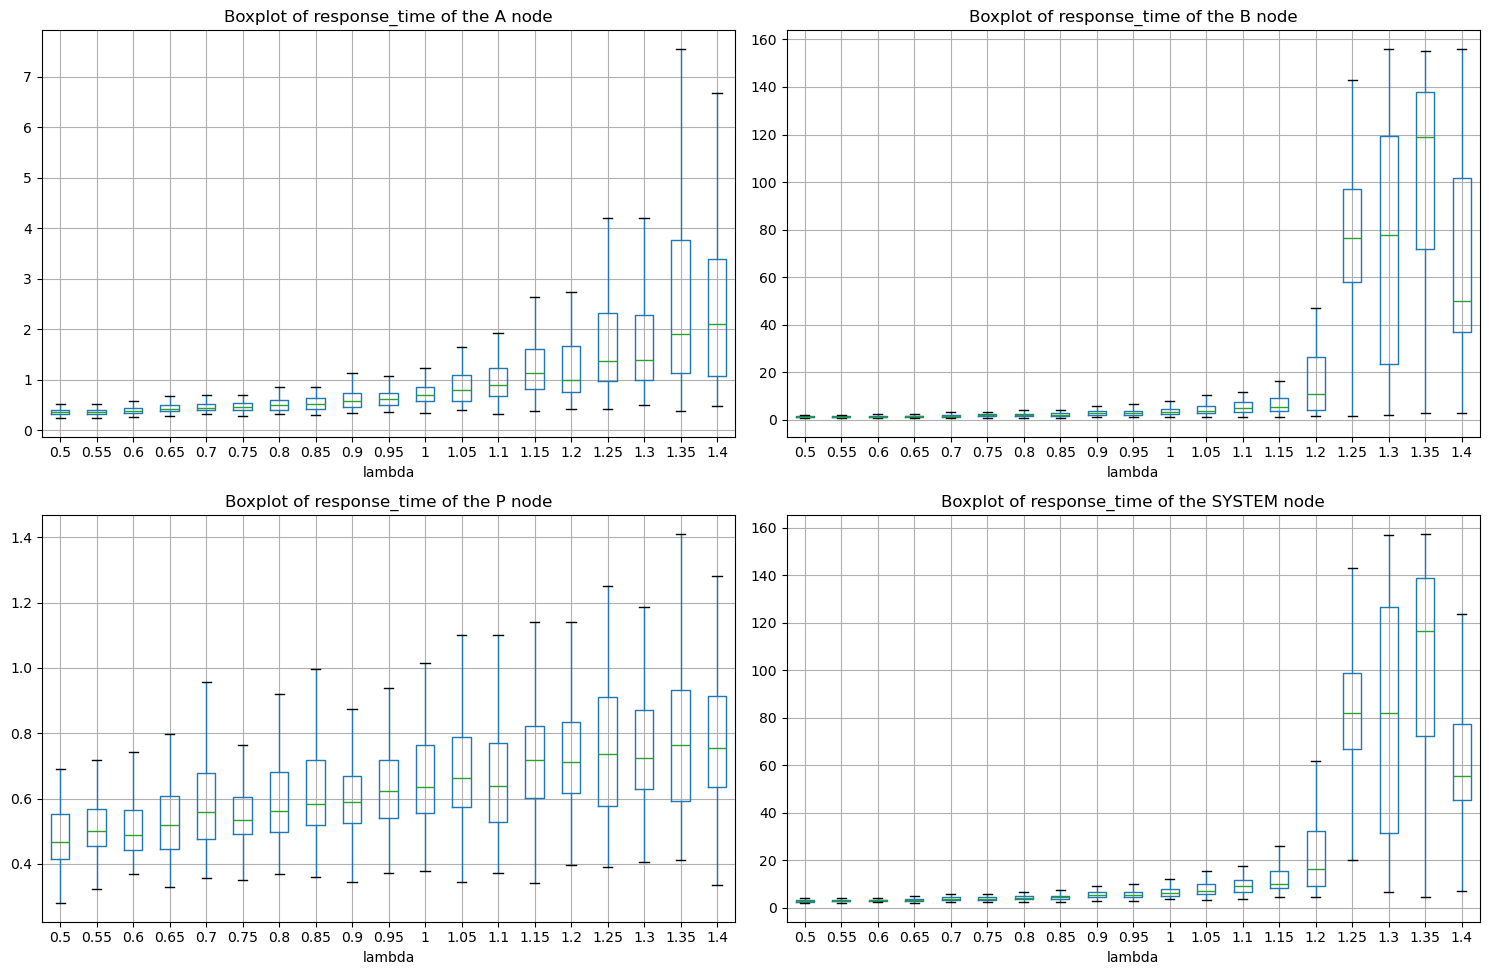

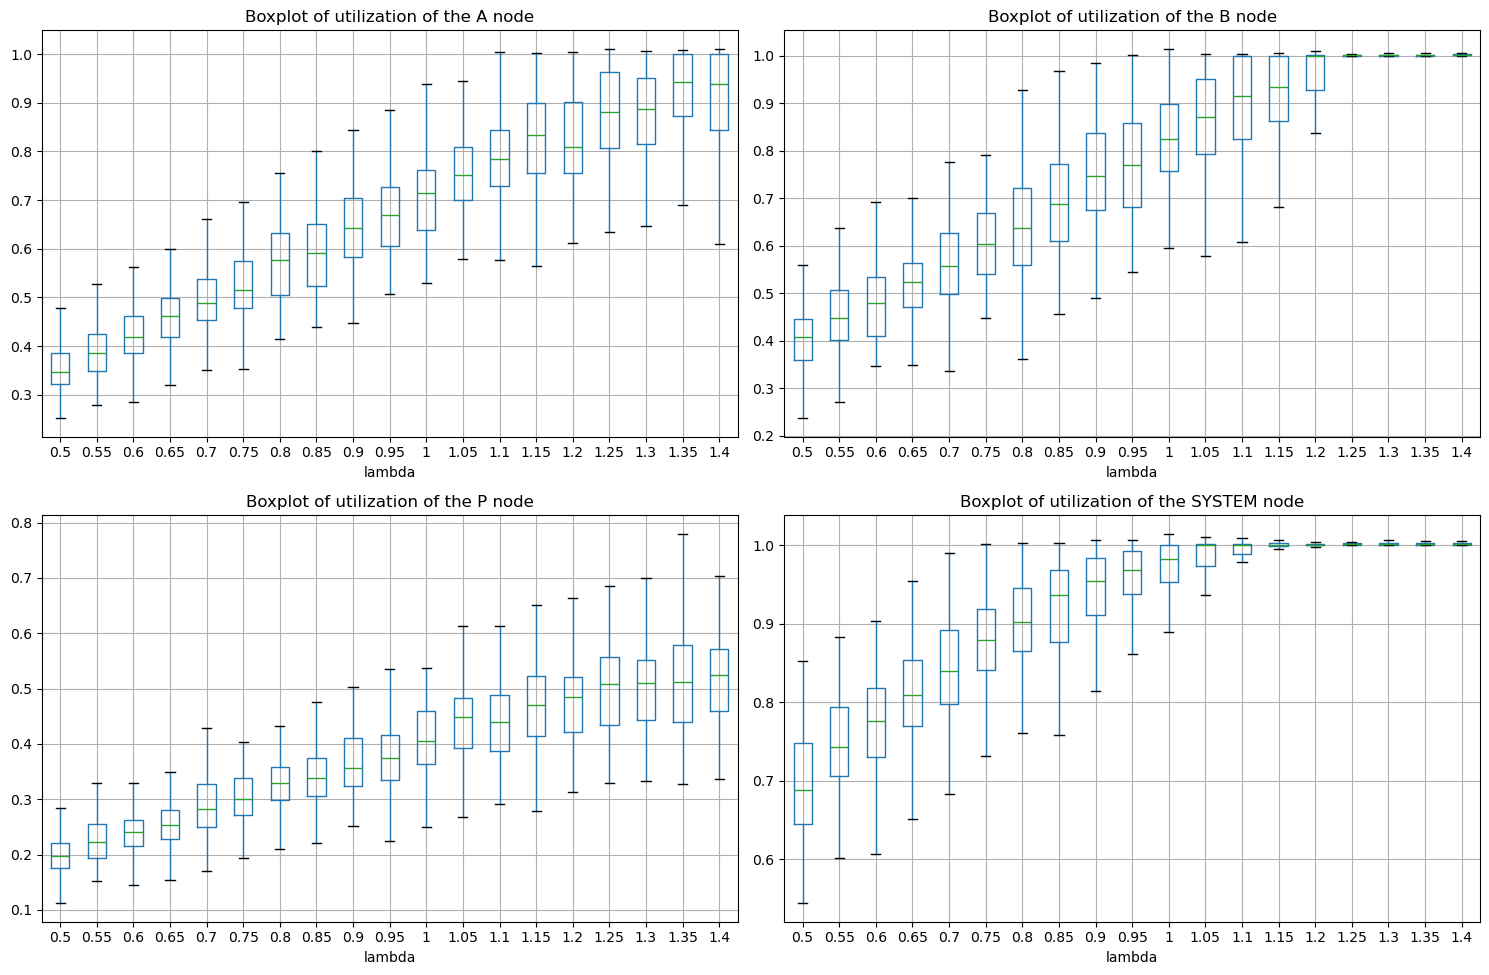

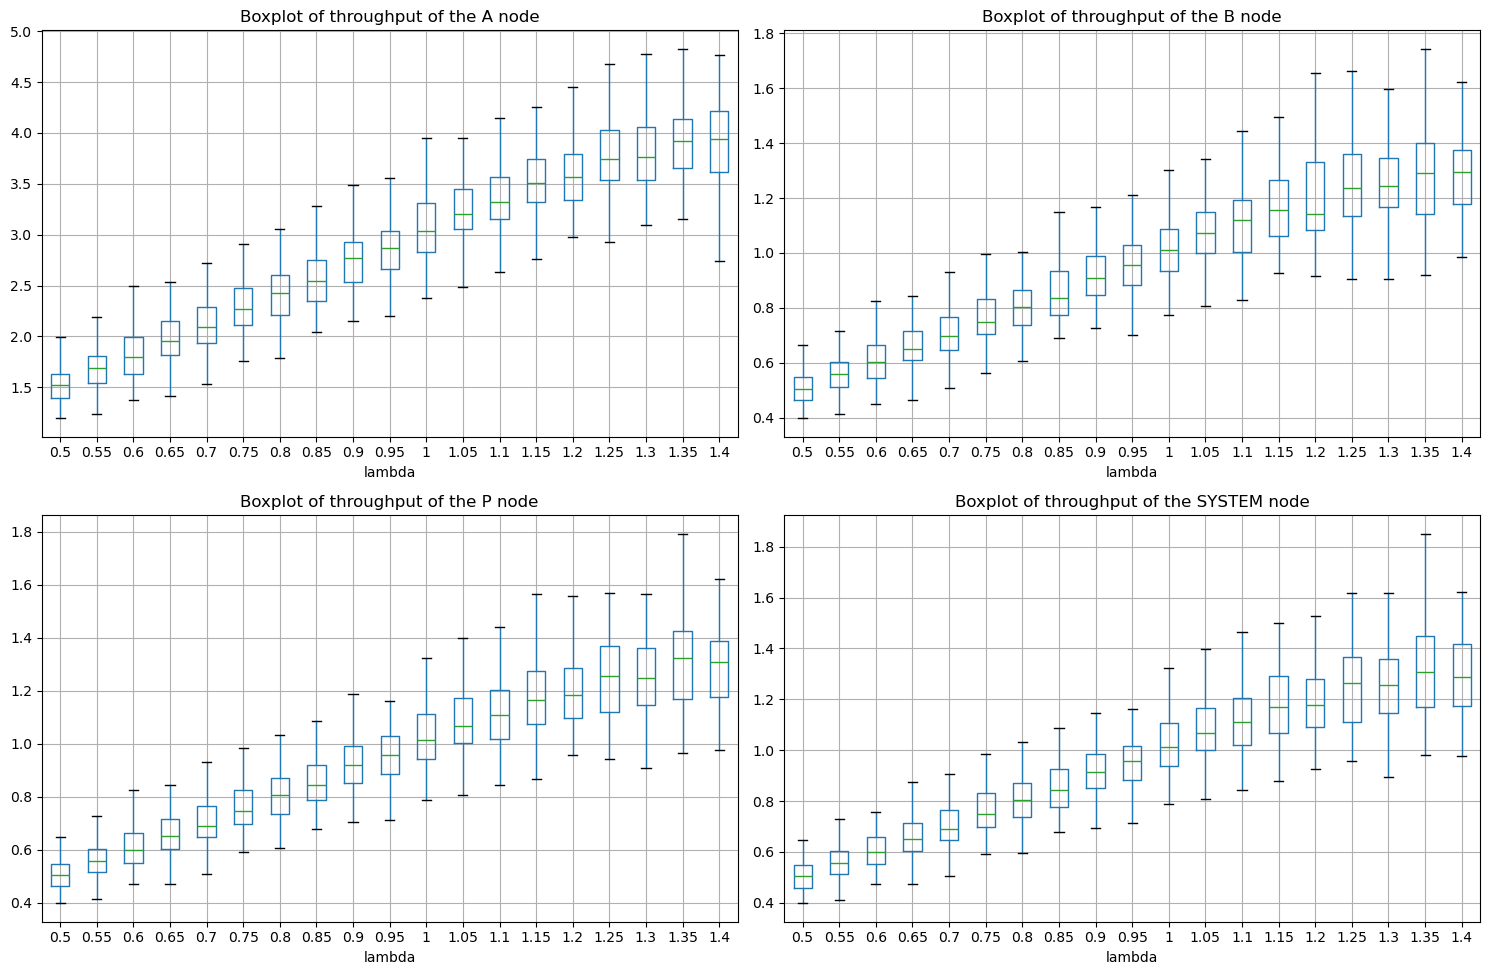

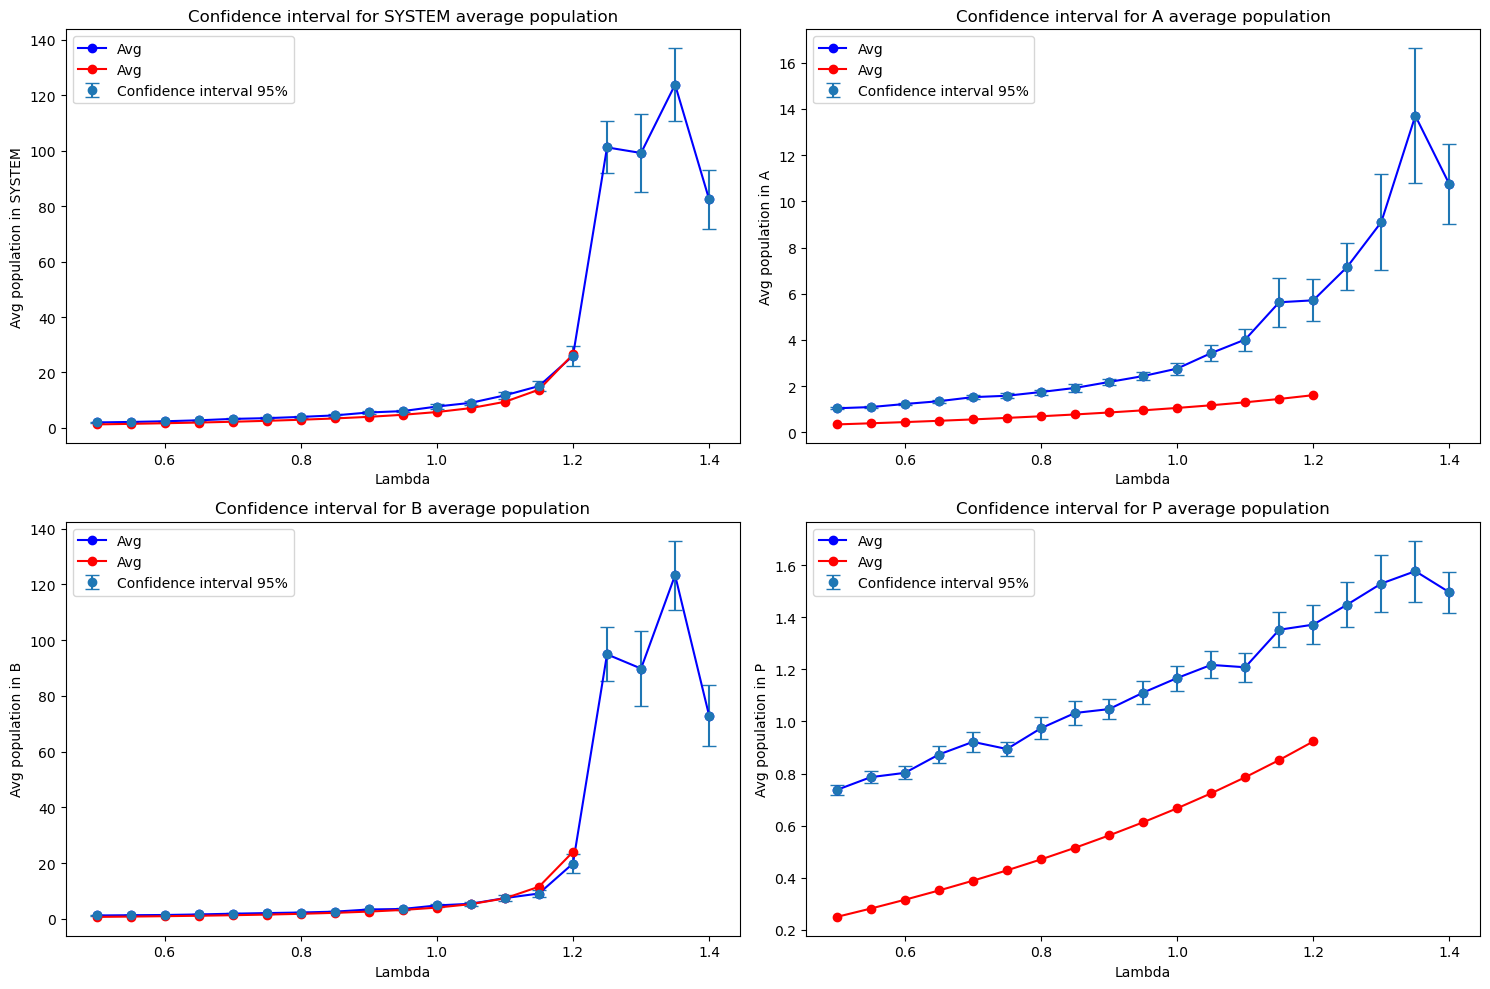

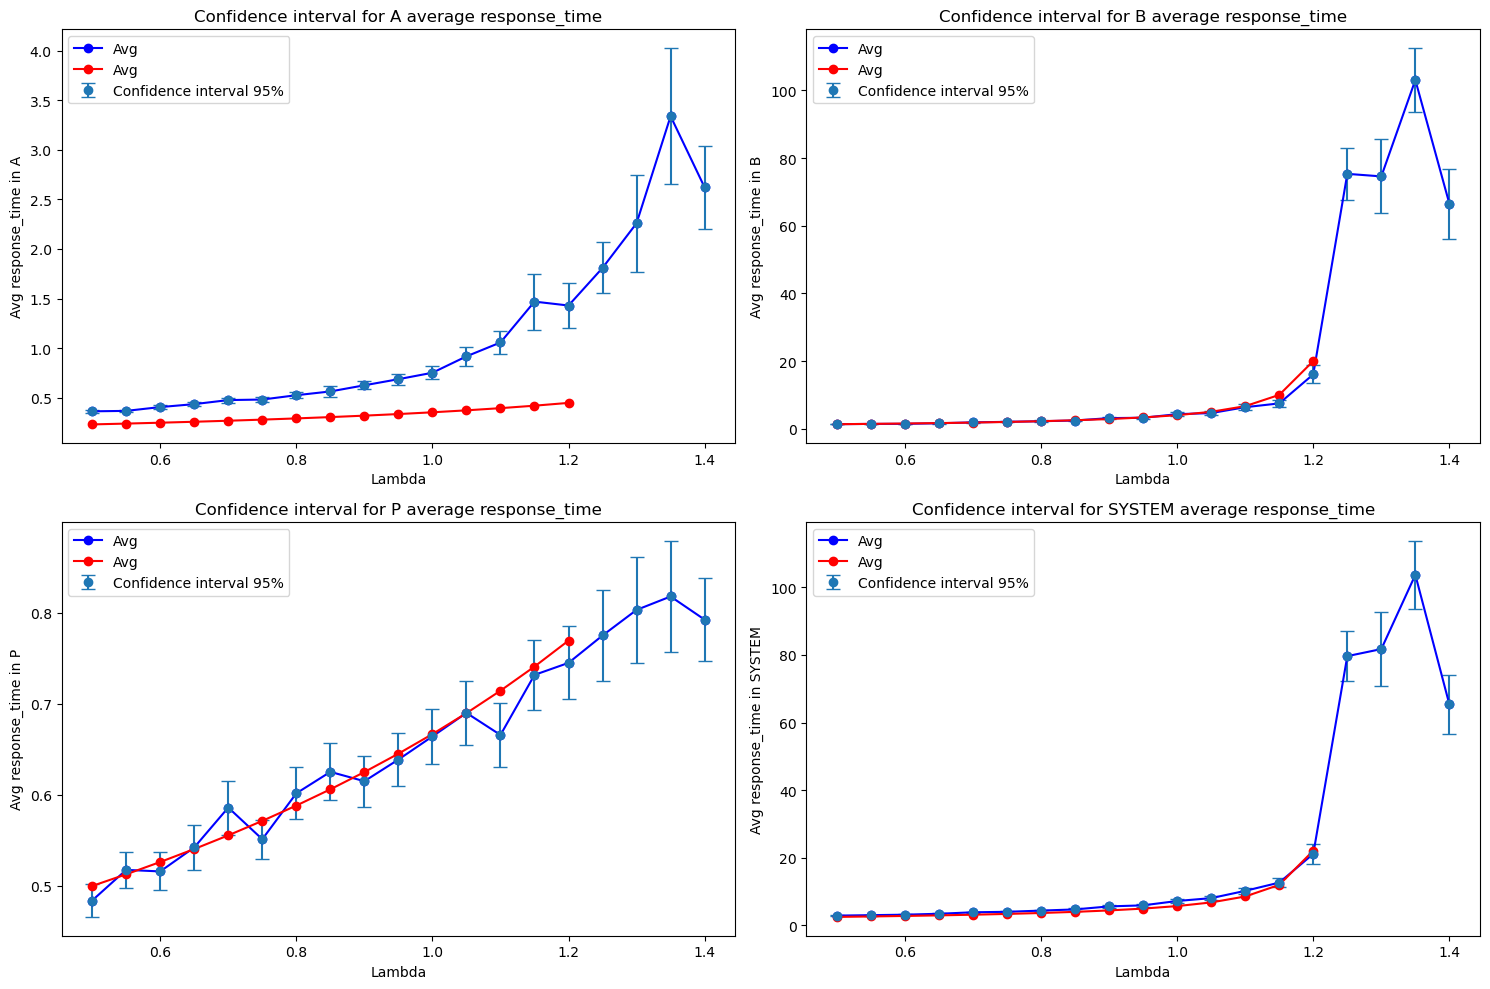

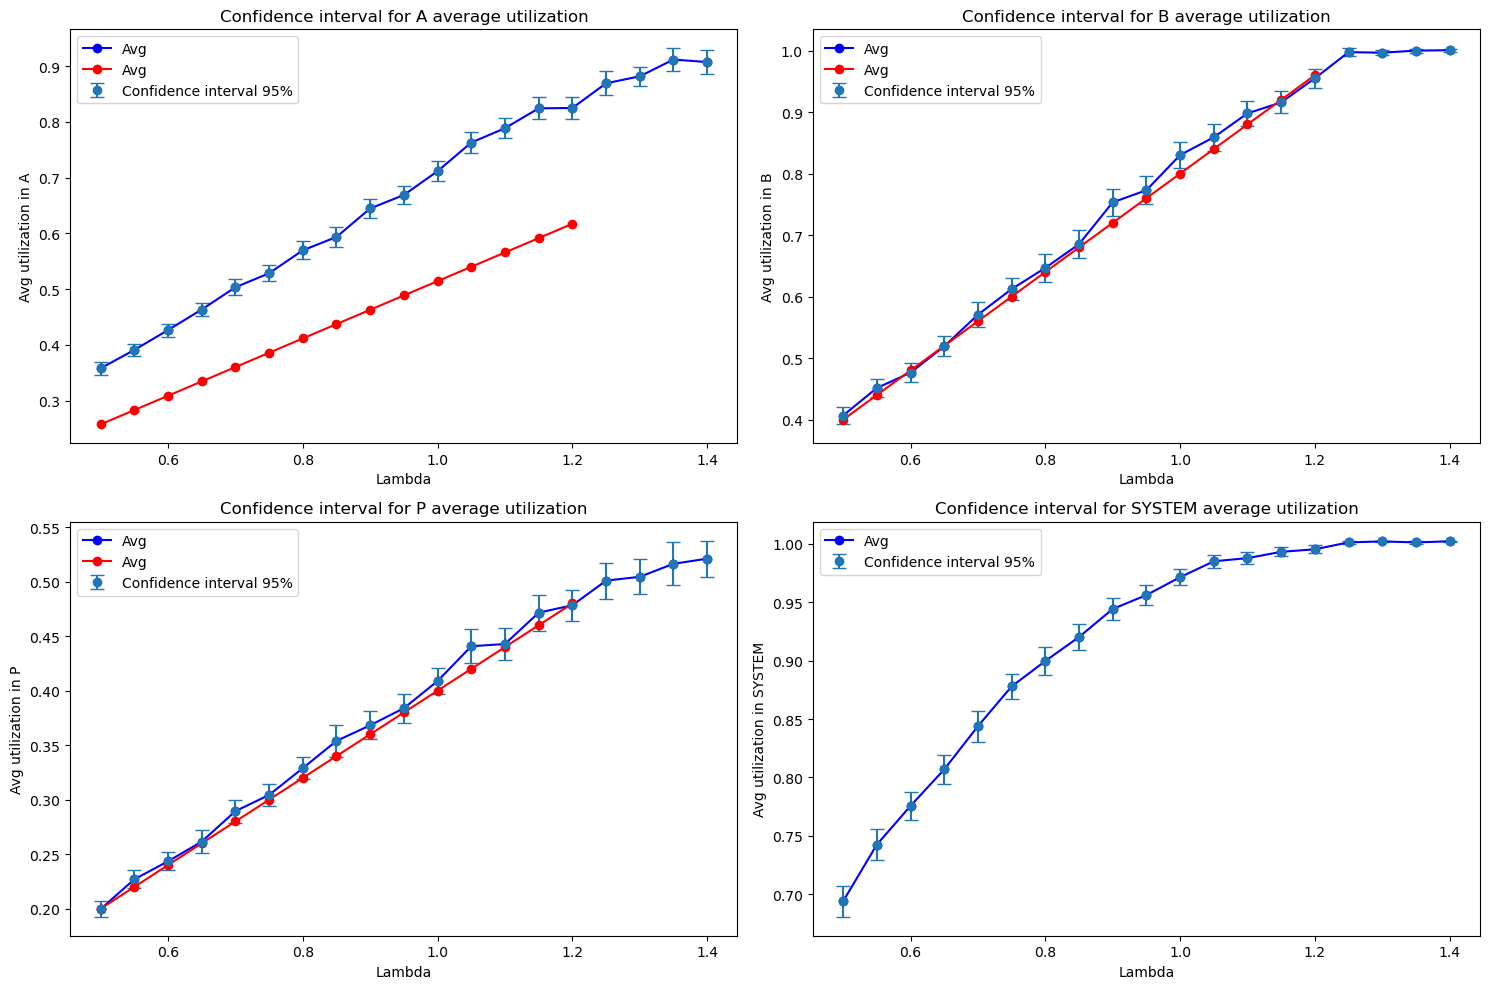

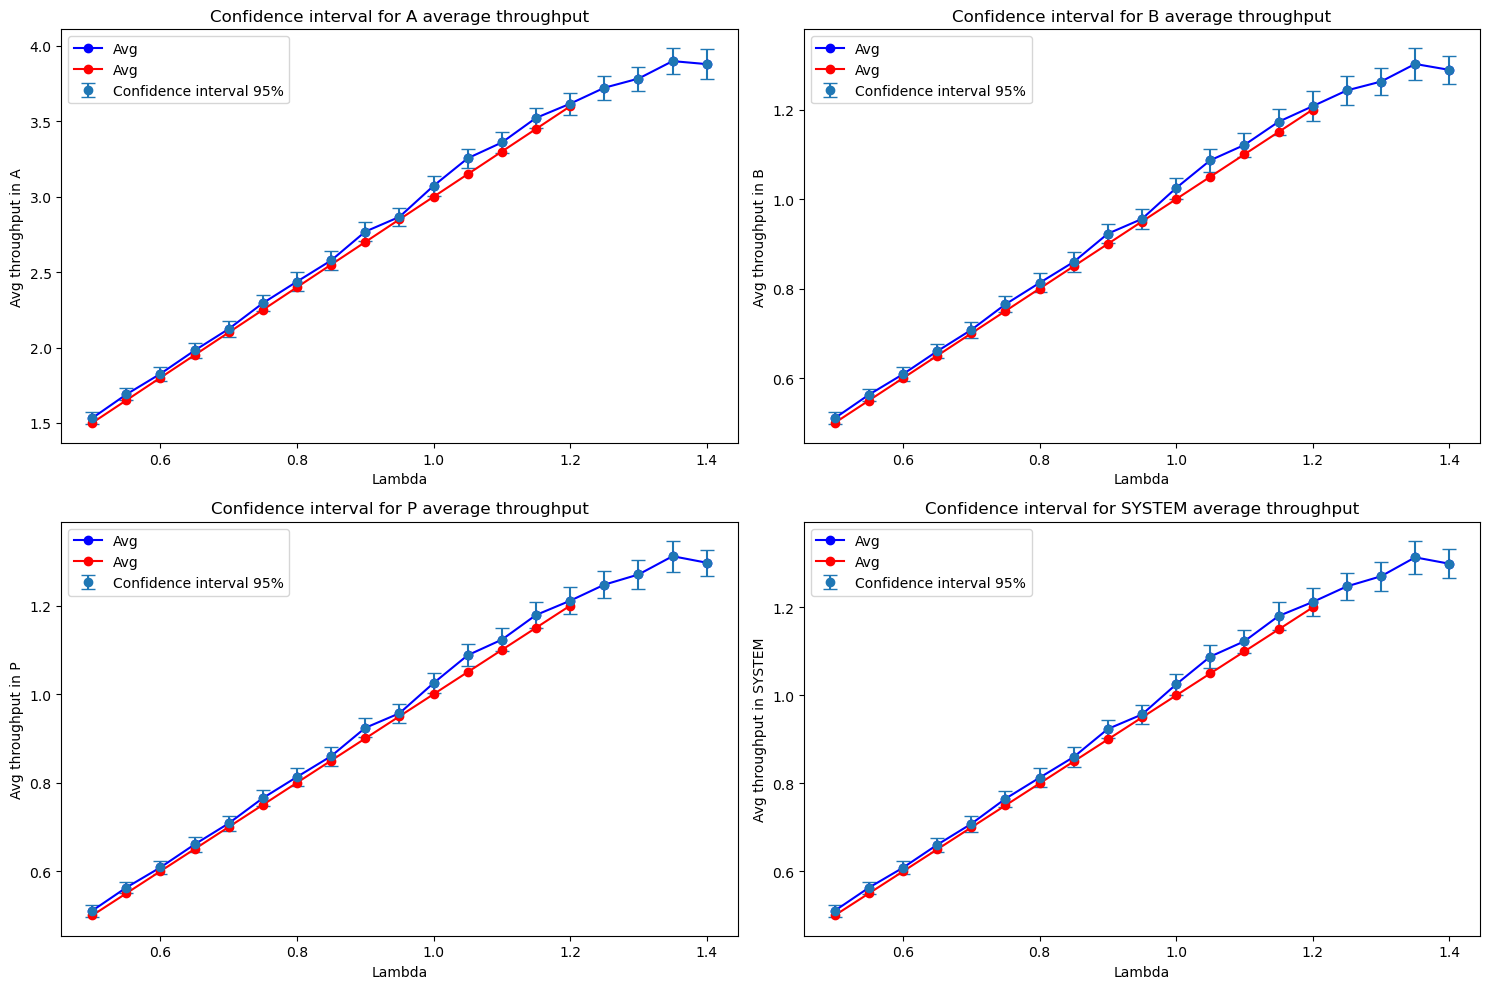

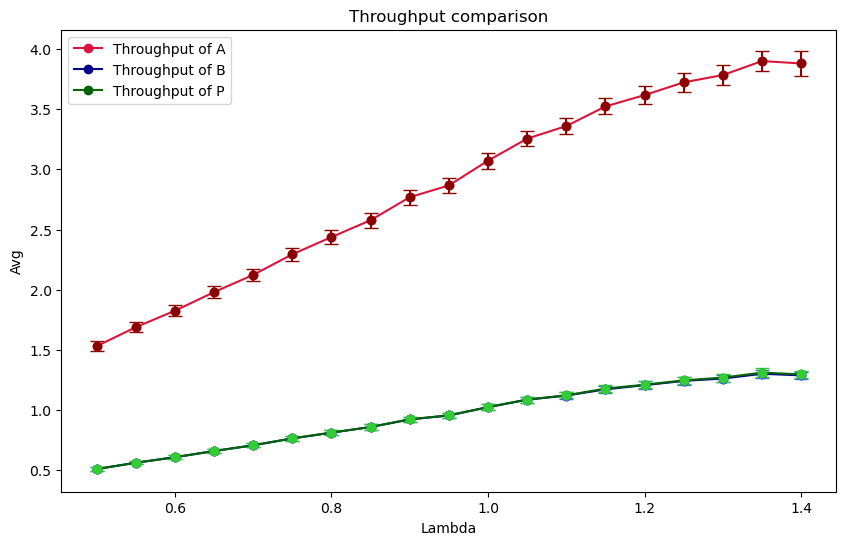

lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,SYSTEM,1.97065,1.26282,0.707828
0.55,population,SYSTEM,2.1537,1.46219,0.691509
0.6,population,SYSTEM,2.39253,1.68515,0.707385
0.65,population,SYSTEM,2.74384,1.93683,0.807012
0.7,population,SYSTEM,3.25477,2.22412,1.03066
0.75,population,SYSTEM,3.51897,2.55648,0.962487
0.8,population,SYSTEM,3.97514,2.9474,1.02775
0.85,population,SYSTEM,4.51231,3.4168,1.09551
0.9,population,SYSTEM,5.5708,3.99563,1.57516
0.95,population,SYSTEM,6.06004,4.73488,1.32516


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,A,1.04519,0.346154,0.699035
0.55,population,A,1.09645,0.394422,0.702024
0.6,population,A,1.22952,0.446281,0.783235
0.65,population,A,1.35082,0.502146,0.84867
0.7,population,A,1.52587,0.5625,0.96337
0.75,population,A,1.58672,0.627907,0.958809
0.8,population,A,1.74787,0.699029,1.04884
0.85,population,A,1.92426,0.77665,1.14761
0.9,population,A,2.18144,0.861702,1.31974
0.95,population,A,2.43727,0.955307,1.48196


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,B,1.18329,0.666667,0.516628
0.55,population,B,1.27779,0.785714,0.492075
0.6,population,B,1.35673,0.923077,0.433648
0.65,population,B,1.55024,1.08333,0.466908
0.7,population,B,1.81988,1.27273,0.547152
0.75,population,B,2.0375,1.5,0.537503
0.8,population,B,2.24382,1.77778,0.466038
0.85,population,B,2.55092,2.125,0.425923
0.9,population,B,3.32904,2.57143,0.757613
0.95,population,B,3.52048,3.16667,0.35381


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,population,P,0.737179,0.25,0.487179
0.55,population,P,0.786191,0.282051,0.504139
0.6,population,P,0.802667,0.315789,0.486877
0.65,population,P,0.872986,0.351351,0.521634
0.7,population,P,0.921568,0.388889,0.532679
0.75,population,P,0.894148,0.428571,0.465576
0.8,population,P,0.973884,0.470588,0.503296
0.85,population,P,1.03239,0.515152,0.51724
0.9,population,P,1.04724,0.5625,0.484735
0.95,population,P,1.11036,0.612903,0.497456


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,A,0.362781,0.230769,0.132012
0.55,response_time,A,0.367145,0.239044,0.128102
0.6,response_time,A,0.4056,0.247934,0.157666
0.65,response_time,A,0.435253,0.257511,0.177742
0.7,response_time,A,0.476158,0.267857,0.208301
0.75,response_time,A,0.481548,0.27907,0.202479
0.8,response_time,A,0.525219,0.291262,0.233957
0.85,response_time,A,0.563193,0.304569,0.258624
0.9,response_time,A,0.625191,0.319149,0.306042
0.95,response_time,A,0.686799,0.335196,0.351603


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,B,1.3403,1.33333,0.00697038
0.55,response_time,B,1.42299,1.42857,0.00558622
0.6,response_time,B,1.44584,1.53846,0.0926203
0.65,response_time,B,1.61096,1.66667,0.0557067
0.7,response_time,B,1.87914,1.81818,0.0609629
0.75,response_time,B,2.03636,2,0.0363583
0.8,response_time,B,2.21533,2.22222,0.00689104
0.85,response_time,B,2.42657,2.5,0.0734268
0.9,response_time,B,3.13581,2.85714,0.278665
0.95,response_time,B,3.2441,3.33333,0.0892305


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,P,0.484062,0.5,0.0159378
0.55,response_time,P,0.517682,0.512821,0.00486144
0.6,response_time,P,0.515975,0.526316,0.0103411
0.65,response_time,P,0.542309,0.540541,0.00176806
0.7,response_time,P,0.586061,0.555556,0.0305054
0.75,response_time,P,0.55131,0.571429,0.0201189
0.8,response_time,P,0.601672,0.588235,0.0134371
0.85,response_time,P,0.625206,0.606061,0.0191456
0.9,response_time,P,0.614966,0.625,0.0100342
0.95,response_time,P,0.638708,0.645161,0.0064533


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,response_time,SYSTEM,2.91355,2.52564,0.387905
0.55,response_time,SYSTEM,3.04062,2.65852,0.382097
0.6,response_time,SYSTEM,3.18135,2.80858,0.372774
0.65,response_time,SYSTEM,3.45695,2.97974,0.477211
0.7,response_time,SYSTEM,3.89242,3.17731,0.715109
0.75,response_time,SYSTEM,4.0336,3.40864,0.624964
0.8,response_time,SYSTEM,4.39007,3.68424,0.705822
0.85,response_time,SYSTEM,4.74278,4.01977,0.723015
0.9,response_time,SYSTEM,5.63471,4.43959,1.19512
0.95,response_time,SYSTEM,5.94369,4.98408,0.959613


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,A,0.357797,0.257143,0.100654
0.55,utilization,A,0.390762,0.282857,0.107905
0.6,utilization,A,0.426394,0.308571,0.117823
0.65,utilization,A,0.463334,0.334286,0.129048
0.7,utilization,A,0.503179,0.36,0.143179
0.75,utilization,A,0.528385,0.385714,0.14267
0.8,utilization,A,0.569512,0.411429,0.158083
0.85,utilization,A,0.593542,0.437143,0.156399
0.9,utilization,A,0.6447,0.462857,0.181843
0.95,utilization,A,0.668824,0.488571,0.180253


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,B,0.406689,0.4,0.00668945
0.55,utilization,B,0.451406,0.44,0.0114063
0.6,utilization,B,0.476363,0.48,0.00363702
0.65,utilization,B,0.519208,0.52,0.000791979
0.7,utilization,B,0.570593,0.56,0.0105926
0.75,utilization,B,0.612218,0.6,0.0122185
0.8,utilization,B,0.646766,0.64,0.00676586
0.85,utilization,B,0.685269,0.68,0.00526916
0.9,utilization,B,0.753324,0.72,0.0333242
0.95,utilization,B,0.773015,0.76,0.0130149


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,utilization,P,0.199661,0.2,0.00033895
0.55,utilization,P,0.226971,0.22,0.00697078
0.6,utilization,P,0.243466,0.24,0.00346566
0.65,utilization,P,0.261521,0.26,0.00152148
0.7,utilization,P,0.289503,0.28,0.00950324
0.75,utilization,P,0.304344,0.3,0.00434448
0.8,utilization,P,0.328902,0.32,0.00890215
0.85,utilization,P,0.353934,0.34,0.0139341
0.9,utilization,P,0.36825,0.36,0.00824964
0.95,utilization,P,0.383949,0.38,0.00394943


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,A,1.53149,1.5,0.0314949
0.55,throughput,A,1.68893,1.65,0.0389262
0.6,throughput,A,1.82589,1.8,0.0258857
0.65,throughput,A,1.98036,1.95,0.0303626
0.7,throughput,A,2.12344,2.1,0.0234397
0.75,throughput,A,2.29458,2.25,0.0445755
0.8,throughput,A,2.43746,2.4,0.0374614
0.85,throughput,A,2.5778,2.55,0.0278004
0.9,throughput,A,2.76891,2.7,0.0689139
0.95,throughput,A,2.86664,2.85,0.0166371


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,B,0.510446,0.5,0.0104458
0.55,throughput,B,0.562883,0.55,0.0128833
0.6,throughput,B,0.608824,0.6,0.00882405
0.65,throughput,B,0.66005,0.65,0.0100504
0.7,throughput,B,0.707852,0.7,0.00785199
0.75,throughput,B,0.764989,0.75,0.0149894
0.8,throughput,B,0.81286,0.8,0.0128595
0.85,throughput,B,0.859681,0.85,0.00968067
0.9,throughput,B,0.922796,0.9,0.0227956
0.95,throughput,B,0.955772,0.95,0.00577234


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,P,0.5106,0.5,0.0105997
0.55,throughput,P,0.563082,0.55,0.0130818
0.6,throughput,P,0.608598,0.6,0.00859778
0.65,throughput,P,0.660546,0.65,0.0105459
0.7,throughput,P,0.708191,0.7,0.00819061
0.75,throughput,P,0.765277,0.75,0.0152773
0.8,throughput,P,0.813098,0.8,0.0130985
0.85,throughput,P,0.859997,0.85,0.00999726
0.9,throughput,P,0.9239,0.9,0.0238995
0.95,throughput,P,0.956864,0.95,0.00686381


lambda,metric,node,simulation_value,analitycal_value,diff
0.5,throughput,SYSTEM,0.510499,0.5,0.010499
0.55,throughput,SYSTEM,0.563028,0.55,0.0130284
0.6,throughput,SYSTEM,0.60847,0.6,0.00847035
0.65,throughput,SYSTEM,0.660502,0.65,0.0105023
0.7,throughput,SYSTEM,0.70814,0.7,0.0081401
0.75,throughput,SYSTEM,0.765229,0.75,0.0152286
0.8,throughput,SYSTEM,0.813022,0.8,0.0130217
0.85,throughput,SYSTEM,0.860083,0.85,0.0100833
0.9,throughput,SYSTEM,0.923826,0.9,0.0238255
0.95,throughput,SYSTEM,0.956785,0.95,0.00678499


In [31]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_3")
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj3'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analytical_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analytical_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analytical_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))